In [1]:
# Import library
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import time
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.models import load_model
import matplotlib.ticker as ticker
from sklearn import metrics
import scipy.stats as stats
import itertools

In [2]:
# Load SMDR stock dataset
df_smdr = pd.read_excel(
    'transportation_stocks.xlsx', sheet_name='SMDR.JK')
df_smdr.set_index('Date', drop=True, inplace=True)
df_smdr.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-04-01,38000000,38750000,38000000,38000000,19600687,500000
2011-04-04,38750000,38750000,38000000,38750000,19987543,650000
2011-04-05,39750000,40000000,39000000,39750000,20503349,3900000
2011-04-06,41250000,41250000,39750000,41250000,21277061,2100000
2011-04-07,40500000,40500000,40500000,40500000,20890205,1000000


In [3]:
# Check datatypes
print(df_smdr.dtypes)

Open         int64
High         int64
Low          int64
Close        int64
Adj Close    int64
Volume       int64
dtype: object


In [4]:
# Check missing value
print(df_smdr.isnull().sum())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [5]:
# Fill missing value using mean imputation
# for i in df_smdr[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]:
#     df_smdr[i].fillna(df_smdr[i].mean(), inplace=True)

# print(df_smdr.isnull().sum())

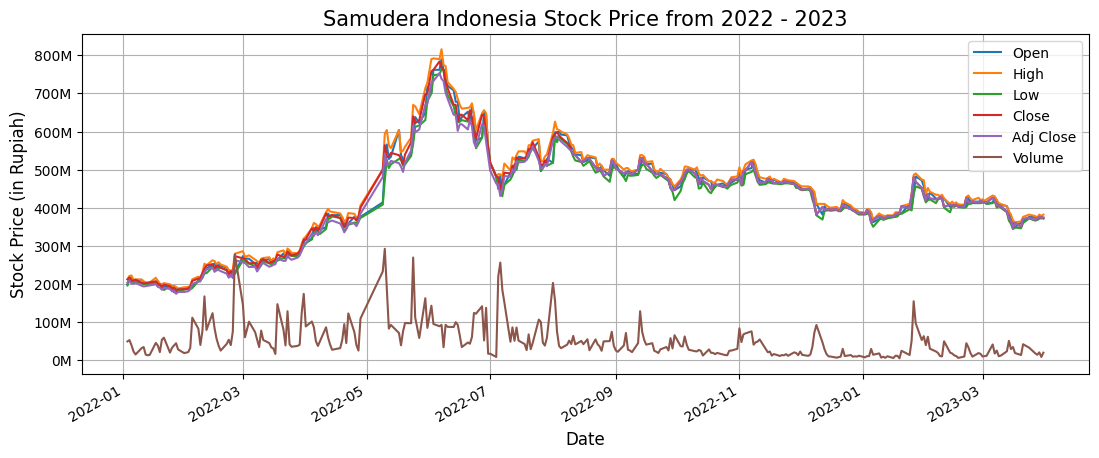

In [6]:
# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# Visualize the historical prices from 2021 - 2022
df_smdr['2022':].plot(figsize=(13,5))
plt.title('Samudera Indonesia Stock Price from 2022 - 2023', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

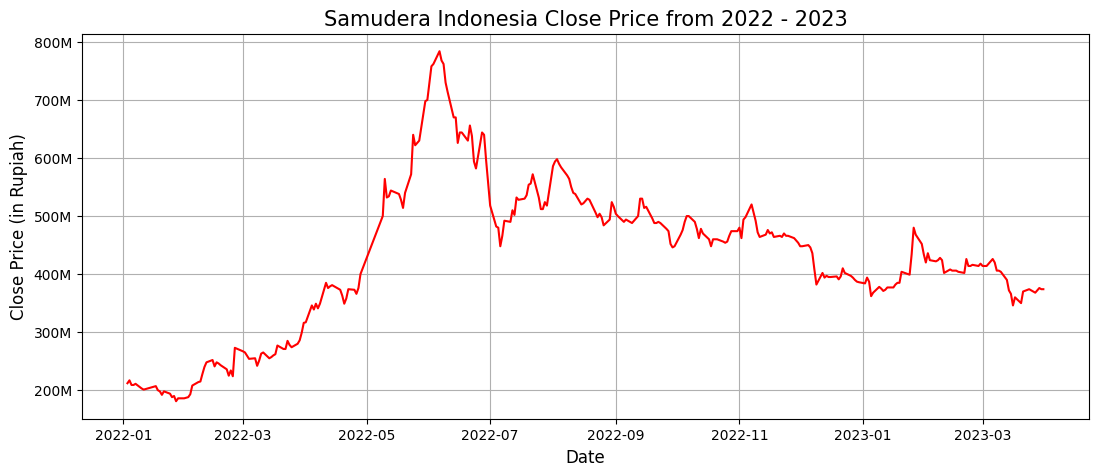

In [7]:
# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# Visualize each of price attributes
plt.figure(figsize=(13,5))
plt.plot(df_smdr['Close']['2022':], color='red')
plt.title('Samudera Indonesia Close Price from 2022 - 2023', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

In [8]:
# Select the close price column as the target variable
target_col = 'Close'

# Create a new dataframe with only the target variable
target_df = pd.DataFrame(df_smdr[target_col])

# Split the data into training and testing sets
train_size = int(len(target_df) * 0.9)
train_df = target_df[:train_size]
test_df = target_df[train_size:]
print('Training Set: ', train_df.shape)
print('Testing Set: ', test_df.shape)

Training Set:  (2682, 1)
Testing Set:  (298, 1)


In [9]:
# Scale the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_df)
test_scaled = scaler.transform(test_df)
print('Training Scaled: ', train_scaled[0:5], '\n')
print('Testing Scaled: ', test_scaled[0:5])

Training Scaled:  [[0.07284768]
 [0.07639546]
 [0.08112583]
 [0.08822138]
 [0.0846736 ]] 

Testing Scaled:  [[0.87228004]
 [0.83916746]
 [0.82970672]
 [0.8013245 ]
 [0.82970672]]


In [10]:
# Define the sequence length and number of features
sequence_length = 60
num_features = 1

# Define the function to create sequences
def create_sequences(X, y, seq_length):
    X_sequences, y_sequences = [], []
    for i in range(seq_length, len(X)):
        X_sequences.append(X[i-seq_length:i, :])
        y_sequences.append(y[i, :])
    return np.array(X_sequences), np.array(y_sequences)

# Create training sequences and labels
X_train, y_train = create_sequences(train_scaled, train_scaled, sequence_length)

# Create testing sequences and labels
X_test, y_test = create_sequences(test_scaled, test_scaled, sequence_length)

# Print the shape of the training and testing sets
print('X train shape:', X_train.shape)
print('y train shape:', y_train.shape)
print('X test shape:', X_test.shape)
print('y test shape:', y_test.shape)

X train shape: (2622, 60, 1)
y train shape: (2622, 1)
X test shape: (238, 60, 1)
y test shape: (238, 1)


##### LSTM Network Default Model

In [11]:
# define the model
model = Sequential()
model.add(LSTM(32, input_shape=(sequence_length, num_features)))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error')
# train the model
model.fit(X_train, y_train, epochs=10, 
          batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 5s 61ms/step - loss: 0.0025 - val_loss: 0.0071
Epoch 2/10
24/24 [==============================] - 1s 27ms/step - loss: 4.6824e-04 - val_loss: 0.0057
Epoch 3/10
24/24 [==============================] - 1s 27ms/step - loss: 4.4680e-04 - val_loss: 0.0032
Epoch 4/10
24/24 [==============================] - 1s 27ms/step - loss: 4.1251e-04 - val_loss: 0.0031
Epoch 5/10
24/24 [==============================] - 1s 28ms/step - loss: 4.0761e-04 - val_loss: 0.0022
Epoch 6/10
24/24 [==============================] - 1s 27ms/step - loss: 3.5683e-04 - val_loss: 0.0017
Epoch 7/10
24/24 [==============================] - 1s 28ms/step - loss: 3.3757e-04 - val_loss: 0.0021
Epoch 8/10
24/24 [==============================] - 1s 28ms/step - loss: 3.5687e-04 - val_loss: 0.0025
Epoch 9/10
24/24 [==============================] - 1s 28ms/step - loss: 3.0257e-04 - val_loss: 0.0024
Epoch 10/10
24/24 [==============================] - 1s 27ms/step - loss: 3.0

In [12]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 1s 8ms/step
Mean Absolute Percentage Error (MAPE):  0.25408
Mean Absolute Error (MAE):  0.580519
Mean Squared Error (MSE):  0.4322655
Root Mean Squared Error (RMSE):  0.65747
R-Squared:  -1.401071


8/8 [==============================] - 0s 8ms/step


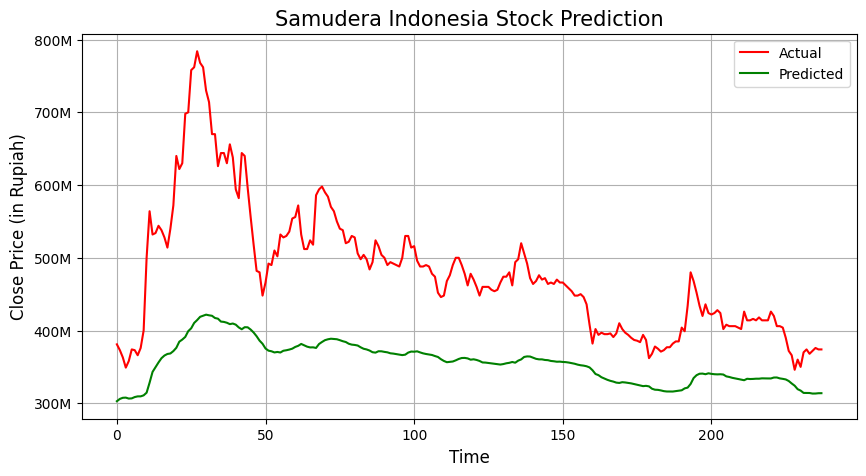

In [13]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Samudera Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

# Save the default model
model.save('models/smdr_lstm_default.h5')

##### Linear - Adam

In [14]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 14s 298ms/step - loss: 0.0040 - val_loss: 0.0047
Epoch 2/10
24/24 [==============================] - 8s 333ms/step - loss: 7.6548e-04 - val_loss: 0.0050
Epoch 3/10
24/24 [==============================] - 8s 323ms/step - loss: 5.6811e-04 - val_loss: 0.0028
Epoch 4/10
24/24 [==============================] - 7s 299ms/step - loss: 4.8384e-04 - val_loss: 0.0024
Epoch 5/10
24/24 [==============================] - 7s 310ms/step - loss: 4.6275e-04 - val_loss: 0.0028
Epoch 6/10
24/24 [==============================] - 7s 301ms/step - loss: 4.3633e-04 - val_loss: 0.0034
Epoch 7/10
24/24 [==============================] - 7s 283ms/step - loss: 4.4362e-04 - val_loss: 0.0019
Epoch 8/10
24/24 [==============================] - 7s 288ms/step - loss: 4.2196e-04 - val_loss: 0.0020
Epoch 9/10
24/24 [==============================] - 7s 285ms/step - loss: 4.0055e-04 - val_loss: 0.0018
Epoch 10/10
24/24 [==============================] - 7s 312ms/step 

In [15]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 28ms/step
Mean Absolute Percentage Error (MAPE):  0.13372
Mean Absolute Error (MAE):  0.3020432
Mean Squared Error (MSE):  0.1251596
Root Mean Squared Error (RMSE):  0.35378
R-Squared:  0.304786


8/8 [==============================] - 0s 29ms/step


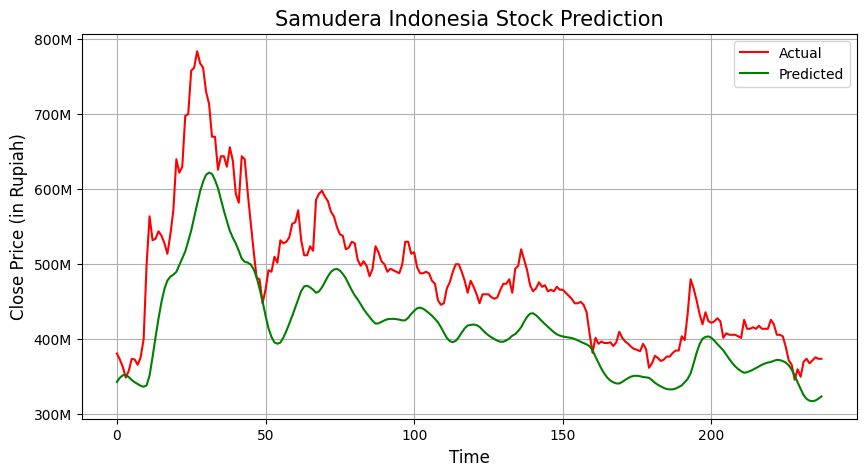

In [16]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Samudera Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

# Save the default model
model.save('models/smdr_linear_adam.h5')

##### Linear - AdaGrad

In [17]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 14s 305ms/step - loss: 0.0197 - val_loss: 0.1624
Epoch 2/10
24/24 [==============================] - 5s 206ms/step - loss: 0.0115 - val_loss: 0.1383
Epoch 3/10
24/24 [==============================] - 5s 217ms/step - loss: 0.0095 - val_loss: 0.1270
Epoch 4/10
24/24 [==============================] - 6s 230ms/step - loss: 0.0091 - val_loss: 0.1210
Epoch 5/10
24/24 [==============================] - 6s 230ms/step - loss: 0.0089 - val_loss: 0.1173
Epoch 6/10
24/24 [==============================] - 5s 215ms/step - loss: 0.0088 - val_loss: 0.1151
Epoch 7/10
24/24 [==============================] - 5s 218ms/step - loss: 0.0088 - val_loss: 0.1131
Epoch 8/10
24/24 [==============================] - 6s 250ms/step - loss: 0.0084 - val_loss: 0.1117
Epoch 9/10
24/24 [==============================] - 6s 242ms/step - loss: 0.0084 - val_loss: 0.1095
Epoch 10/10
24/24 [==============================] - 5s 215ms/step - loss: 0.0084 - val_loss: 0.108

In [18]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 30ms/step
Mean Absolute Percentage Error (MAPE):  0.84329
Mean Absolute Error (MAE):  1.8283296
Mean Squared Error (MSE):  3.5123657
Root Mean Squared Error (RMSE):  1.87413
R-Squared:  -18.509857


8/8 [==============================] - 0s 34ms/step


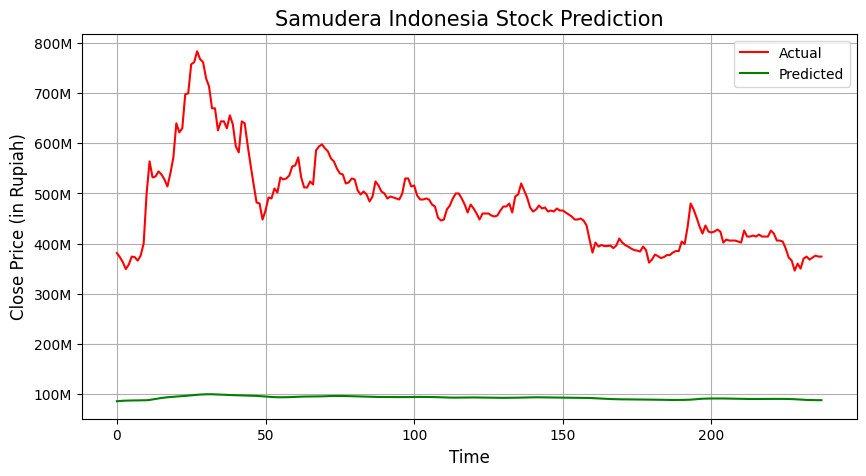

In [19]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Samudera Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/smdr_linear_adagrad.h5')

##### Linear - Nadam

In [20]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 15s 289ms/step - loss: 0.0049 - val_loss: 0.0030
Epoch 2/10
24/24 [==============================] - 5s 210ms/step - loss: 7.2146e-04 - val_loss: 0.0026
Epoch 3/10
24/24 [==============================] - 5s 220ms/step - loss: 5.9039e-04 - val_loss: 0.0024
Epoch 4/10
24/24 [==============================] - 6s 231ms/step - loss: 5.5030e-04 - val_loss: 0.0027
Epoch 5/10
24/24 [==============================] - 6s 234ms/step - loss: 4.9644e-04 - val_loss: 0.0031
Epoch 6/10
24/24 [==============================] - 6s 243ms/step - loss: 4.9561e-04 - val_loss: 0.0024
Epoch 7/10
24/24 [==============================] - 6s 231ms/step - loss: 4.1354e-04 - val_loss: 0.0043
Epoch 8/10
24/24 [==============================] - 5s 220ms/step - loss: 4.2459e-04 - val_loss: 0.0021
Epoch 9/10
24/24 [==============================] - 5s 230ms/step - loss: 3.9762e-04 - val_loss: 0.0021
Epoch 10/10
24/24 [==============================] - 6s 250ms/step 

In [21]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 39ms/step
Mean Absolute Percentage Error (MAPE):  0.18372
Mean Absolute Error (MAE):  0.4085994
Mean Squared Error (MSE):  0.2045161
Root Mean Squared Error (RMSE):  0.45223
R-Squared:  -0.136009


8/8 [==============================] - 0s 34ms/step


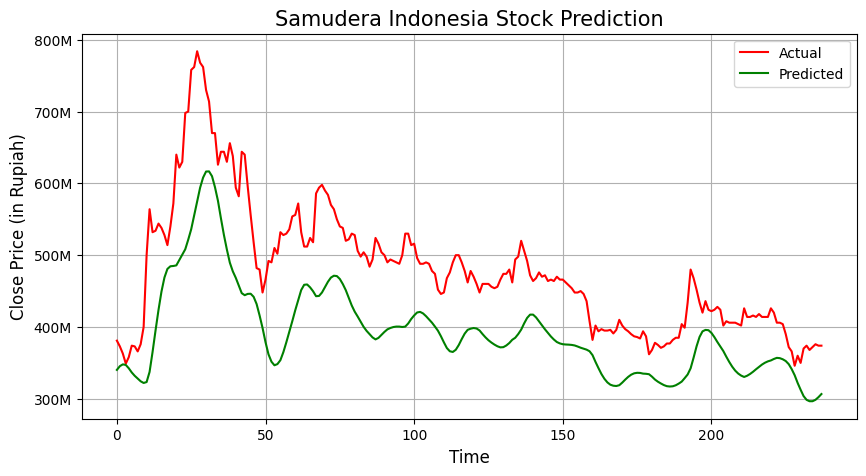

In [22]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Samudera Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/smdr_linear_nadam.h5')

#### Linear - RMSProp

In [23]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 23s 634ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 2/10
24/24 [==============================] - 12s 508ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch 3/10
24/24 [==============================] - 12s 493ms/step - loss: 0.0012 - val_loss: 0.0044
Epoch 4/10
24/24 [==============================] - 12s 492ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 5/10
24/24 [==============================] - 12s 507ms/step - loss: 0.0010 - val_loss: 0.0035
Epoch 6/10
24/24 [==============================] - 12s 499ms/step - loss: 9.1700e-04 - val_loss: 0.0026
Epoch 7/10
24/24 [==============================] - 12s 514ms/step - loss: 8.0904e-04 - val_loss: 0.0021
Epoch 8/10
24/24 [==============================] - 12s 494ms/step - loss: 8.3233e-04 - val_loss: 0.0022
Epoch 9/10
24/24 [==============================] - 12s 498ms/step - loss: 7.8051e-04 - val_loss: 0.0026
Epoch 10/10
24/24 [==============================] - 12s 516ms/step - loss:

In [24]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 42ms/step
Mean Absolute Percentage Error (MAPE):  0.14558
Mean Absolute Error (MAE):  0.3422508
Mean Squared Error (MSE):  0.1863076
Root Mean Squared Error (RMSE):  0.43163
R-Squared:  -0.034868


8/8 [==============================] - 0s 42ms/step


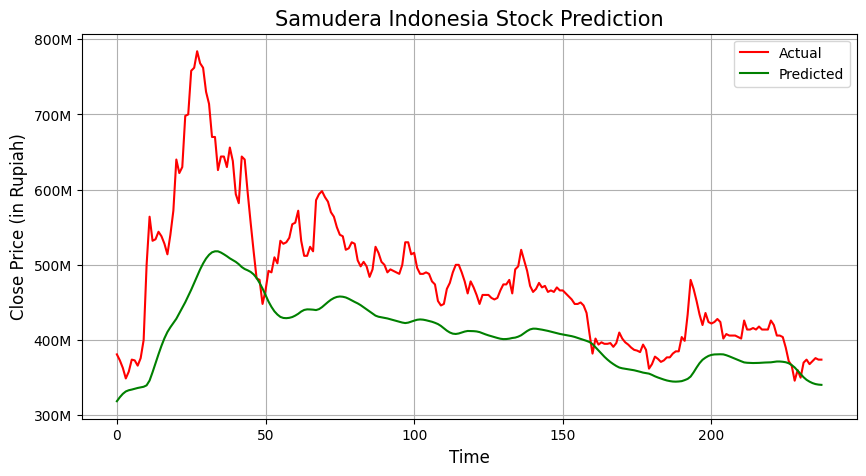

In [25]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Samudera Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/smdr_linear_rmsprop.h5')

##### Linear - AdaDelta

In [26]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 18s 456ms/step - loss: 0.0326 - val_loss: 0.2430
Epoch 2/10
24/24 [==============================] - 9s 357ms/step - loss: 0.0318 - val_loss: 0.2386
Epoch 3/10
24/24 [==============================] - 9s 362ms/step - loss: 0.0312 - val_loss: 0.2342
Epoch 4/10
24/24 [==============================] - 9s 361ms/step - loss: 0.0299 - val_loss: 0.2299
Epoch 5/10
24/24 [==============================] - 9s 360ms/step - loss: 0.0294 - val_loss: 0.2256
Epoch 6/10
24/24 [==============================] - 9s 374ms/step - loss: 0.0282 - val_loss: 0.2214
Epoch 7/10
24/24 [==============================] - 9s 376ms/step - loss: 0.0275 - val_loss: 0.2170
Epoch 8/10
24/24 [==============================] - 9s 379ms/step - loss: 0.0269 - val_loss: 0.2128
Epoch 9/10
24/24 [==============================] - 9s 378ms/step - loss: 0.0260 - val_loss: 0.2087
Epoch 10/10
24/24 [==============================] - 9s 373ms/step - loss: 0.0251 - val_loss: 0.204

In [27]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 39ms/step
Mean Absolute Percentage Error (MAPE):  0.94394
Mean Absolute Error (MAE):  2.0397423
Mean Squared Error (MSE):  4.3382107
Root Mean Squared Error (RMSE):  2.08284
R-Squared:  -23.097112


8/8 [==============================] - 0s 38ms/step


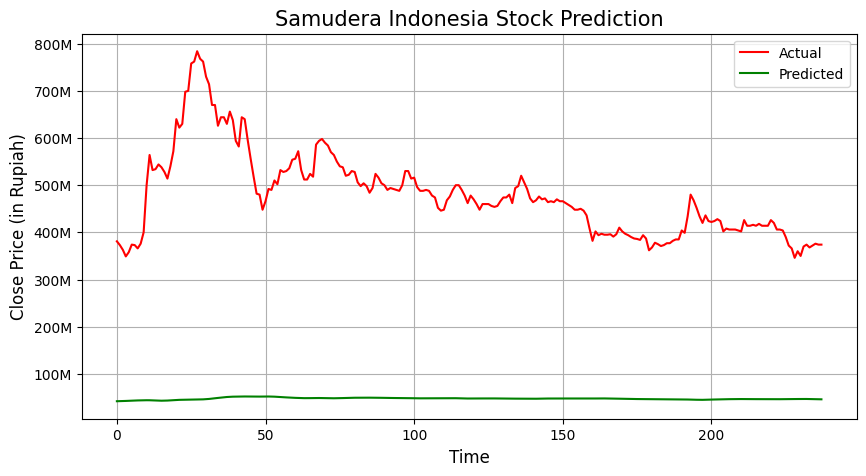

In [28]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Samudera Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/smdr_linear_adadelta.h5')

##### Linear - SGD

In [29]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 21s 572ms/step - loss: 0.0145 - val_loss: 0.1394
Epoch 2/10
24/24 [==============================] - 11s 466ms/step - loss: 0.0102 - val_loss: 0.1328
Epoch 3/10
24/24 [==============================] - 12s 487ms/step - loss: 0.0098 - val_loss: 0.1272
Epoch 4/10
24/24 [==============================] - 11s 470ms/step - loss: 0.0093 - val_loss: 0.1222
Epoch 5/10
24/24 [==============================] - 11s 478ms/step - loss: 0.0090 - val_loss: 0.1182
Epoch 6/10
24/24 [==============================] - 12s 486ms/step - loss: 0.0086 - val_loss: 0.1125
Epoch 7/10
24/24 [==============================] - 11s 478ms/step - loss: 0.0083 - val_loss: 0.1075
Epoch 8/10
24/24 [==============================] - 11s 475ms/step - loss: 0.0079 - val_loss: 0.1031
Epoch 9/10
24/24 [==============================] - 12s 488ms/step - loss: 0.0076 - val_loss: 0.0983
Epoch 10/10
24/24 [==============================] - 12s 483ms/step - loss: 0.0072 - val_lo

In [30]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 40ms/step
Mean Absolute Percentage Error (MAPE):  0.79277
Mean Absolute Error (MAE):  1.7205991
Mean Squared Error (MSE):  3.1196673
Root Mean Squared Error (RMSE):  1.76626
R-Squared:  -16.328566


8/8 [==============================] - 0s 41ms/step


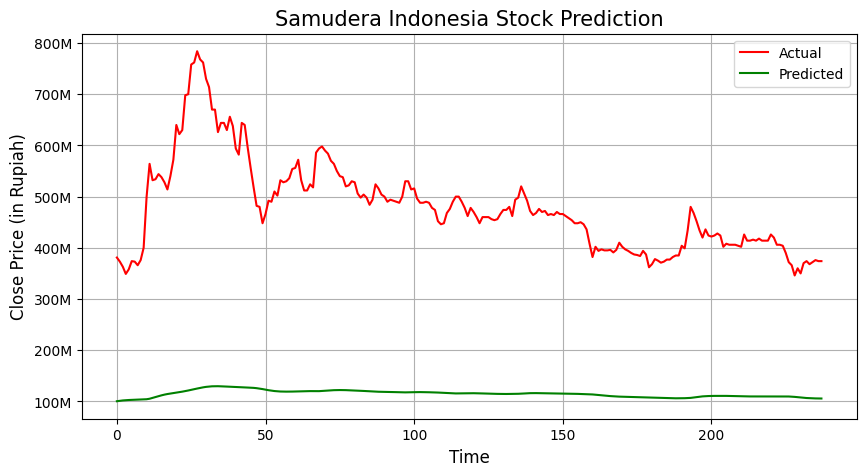

In [31]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Samudera Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/smdr_linear_sgd.h5')

#### Linear - Adamax

In [32]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 23s 655ms/step - loss: 0.0048 - val_loss: 0.0039
Epoch 2/10
24/24 [==============================] - 11s 467ms/step - loss: 9.3870e-04 - val_loss: 0.0027
Epoch 3/10
24/24 [==============================] - 12s 487ms/step - loss: 7.3405e-04 - val_loss: 0.0029
Epoch 4/10
24/24 [==============================] - 11s 453ms/step - loss: 6.0877e-04 - val_loss: 0.0029
Epoch 5/10
24/24 [==============================] - 11s 457ms/step - loss: 6.7087e-04 - val_loss: 0.0027
Epoch 6/10
24/24 [==============================] - 12s 509ms/step - loss: 5.9150e-04 - val_loss: 0.0028
Epoch 7/10
24/24 [==============================] - 13s 527ms/step - loss: 6.1095e-04 - val_loss: 0.0028
Epoch 8/10
24/24 [==============================] - 13s 543ms/step - loss: 5.3868e-04 - val_loss: 0.0030
Epoch 9/10
24/24 [==============================] - 13s 539ms/step - loss: 5.5474e-04 - val_loss: 0.0026
Epoch 10/10
24/24 [==============================] - 13s 53

In [33]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 40ms/step
Mean Absolute Percentage Error (MAPE):  0.06863
Mean Absolute Error (MAE):  0.161459
Mean Squared Error (MSE):  0.058348
Root Mean Squared Error (RMSE):  0.24155
R-Squared:  0.675899


8/8 [==============================] - 0s 55ms/step


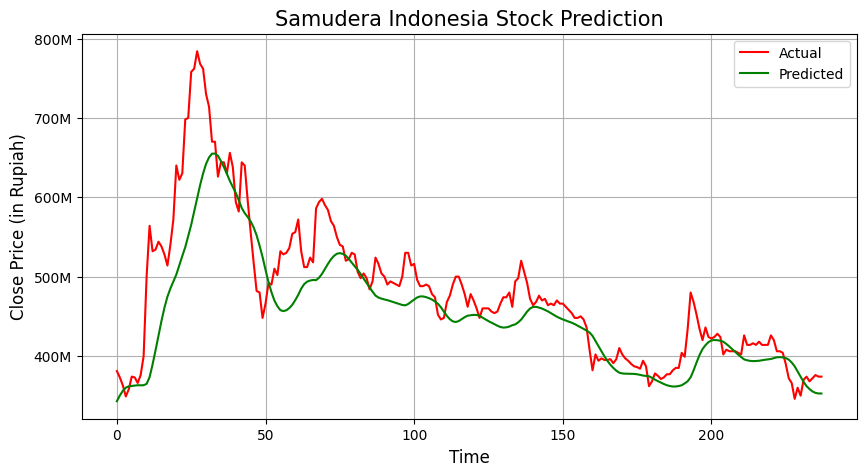

In [34]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Samudera Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/smdr_linear_adamax.h5')

##### ReLU - Adam

In [35]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 20s 434ms/step - loss: 0.0066 - val_loss: 0.0061
Epoch 2/10
24/24 [==============================] - 8s 321ms/step - loss: 0.0010 - val_loss: 0.0028
Epoch 3/10
24/24 [==============================] - 8s 347ms/step - loss: 6.7352e-04 - val_loss: 0.0043
Epoch 4/10
24/24 [==============================] - 7s 273ms/step - loss: 6.7705e-04 - val_loss: 0.0044
Epoch 5/10
24/24 [==============================] - 7s 281ms/step - loss: 5.9758e-04 - val_loss: 0.0051
Epoch 6/10
24/24 [==============================] - 6s 256ms/step - loss: 5.1704e-04 - val_loss: 0.0032
Epoch 7/10
24/24 [==============================] - 6s 266ms/step - loss: 4.2773e-04 - val_loss: 0.0021
Epoch 8/10
24/24 [==============================] - 7s 289ms/step - loss: 4.2258e-04 - val_loss: 0.0020
Epoch 9/10
24/24 [==============================] - 6s 255ms/step - loss: 4.3532e-04 - val_loss: 0.0036
Epoch 10/10
24/24 [==============================] - 7s 272ms/step - lo

In [36]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 38ms/step
Mean Absolute Percentage Error (MAPE):  0.14986
Mean Absolute Error (MAE):  0.335191
Mean Squared Error (MSE):  0.1486578
Root Mean Squared Error (RMSE):  0.38556
R-Squared:  0.174262


8/8 [==============================] - 0s 51ms/step


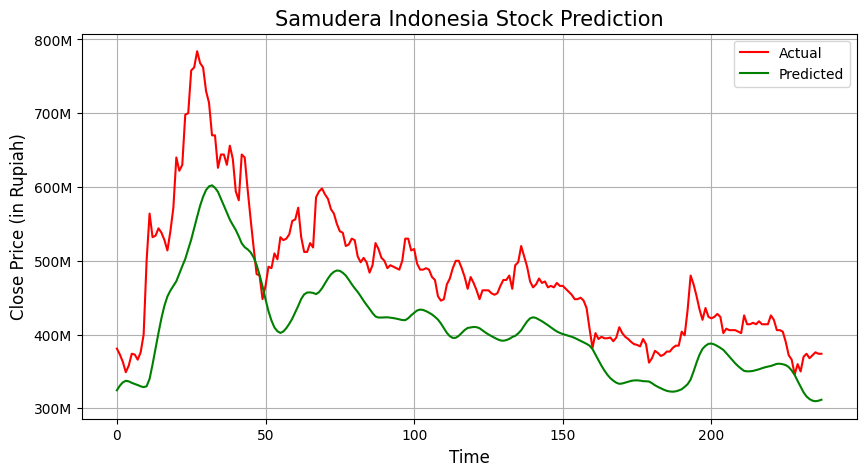

In [37]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Samudera Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/smdr_relu_adam.h5')

#### ReLU - AdaGrad

In [38]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 17s 319ms/step - loss: 0.0195 - val_loss: 0.1540
Epoch 2/10
24/24 [==============================] - 6s 236ms/step - loss: 0.0126 - val_loss: 0.1339
Epoch 3/10
24/24 [==============================] - 6s 239ms/step - loss: 0.0099 - val_loss: 0.1219
Epoch 4/10
24/24 [==============================] - 6s 233ms/step - loss: 0.0087 - val_loss: 0.1139
Epoch 5/10
24/24 [==============================] - 6s 236ms/step - loss: 0.0081 - val_loss: 0.1087
Epoch 6/10
24/24 [==============================] - 6s 232ms/step - loss: 0.0079 - val_loss: 0.1053
Epoch 7/10
24/24 [==============================] - 6s 242ms/step - loss: 0.0077 - val_loss: 0.1028
Epoch 8/10
24/24 [==============================] - 6s 237ms/step - loss: 0.0076 - val_loss: 0.1009
Epoch 9/10
24/24 [==============================] - 6s 252ms/step - loss: 0.0075 - val_loss: 0.0996
Epoch 10/10
24/24 [==============================] - 6s 247ms/step - loss: 0.0075 - val_loss: 0.098

In [39]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 39ms/step
Mean Absolute Percentage Error (MAPE):  0.7822
Mean Absolute Error (MAE):  1.6966567
Mean Squared Error (MSE):  3.0297193
Root Mean Squared Error (RMSE):  1.74061
R-Squared:  -15.828939


8/8 [==============================] - 0s 46ms/step


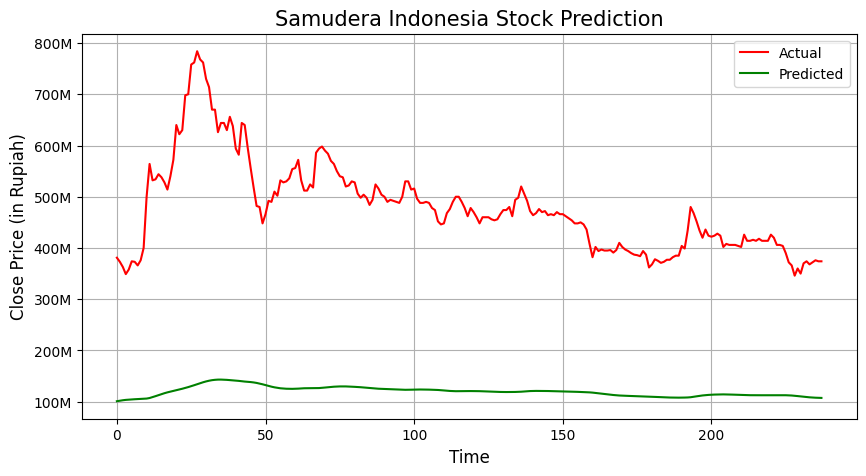

In [40]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Samudera Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/smdr_relu_adagrad.h5')

##### ReLU - Nadam

In [41]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 18s 358ms/step - loss: 0.0045 - val_loss: 0.0046
Epoch 2/10
24/24 [==============================] - 7s 302ms/step - loss: 8.0201e-04 - val_loss: 0.0046
Epoch 3/10
24/24 [==============================] - 6s 268ms/step - loss: 6.5976e-04 - val_loss: 0.0070
Epoch 4/10
24/24 [==============================] - 7s 276ms/step - loss: 5.7342e-04 - val_loss: 0.0044
Epoch 5/10
24/24 [==============================] - 7s 276ms/step - loss: 5.2380e-04 - val_loss: 0.0040
Epoch 6/10
24/24 [==============================] - 6s 261ms/step - loss: 4.8061e-04 - val_loss: 0.0034
Epoch 7/10
24/24 [==============================] - 7s 277ms/step - loss: 4.5747e-04 - val_loss: 0.0039
Epoch 8/10
24/24 [==============================] - 7s 310ms/step - loss: 4.1727e-04 - val_loss: 0.0026
Epoch 9/10
24/24 [==============================] - 6s 269ms/step - loss: 4.1750e-04 - val_loss: 0.0041
Epoch 10/10
24/24 [==============================] - 6s 262ms/step 

In [42]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 35ms/step
Mean Absolute Percentage Error (MAPE):  0.20289
Mean Absolute Error (MAE):  0.4521589
Mean Squared Error (MSE):  0.2492654
Root Mean Squared Error (RMSE):  0.49926
R-Squared:  -0.384574


8/8 [==============================] - 0s 38ms/step


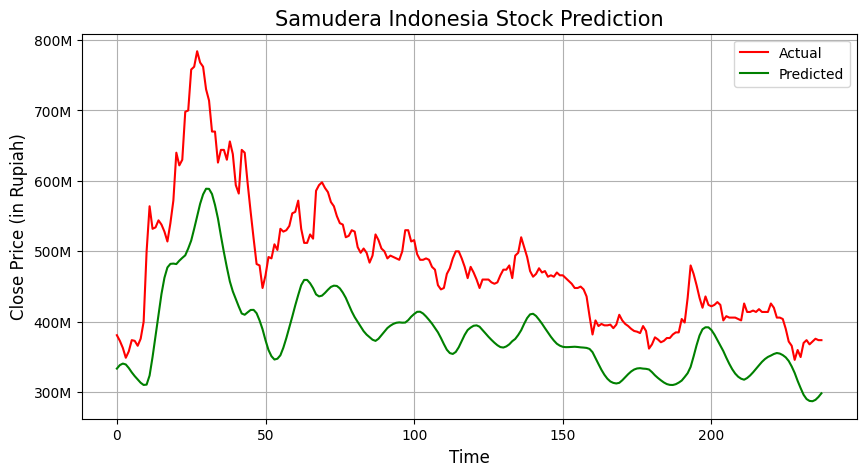

In [43]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Samudera Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/smdr_relu_nadam.h5')

##### ReLU - RMSProp

In [44]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 14s 312ms/step - loss: 0.0054 - val_loss: 0.0107
Epoch 2/10
24/24 [==============================] - 7s 289ms/step - loss: 0.0015 - val_loss: 0.0177
Epoch 3/10
24/24 [==============================] - 7s 277ms/step - loss: 0.0011 - val_loss: 0.0056
Epoch 4/10
24/24 [==============================] - 7s 272ms/step - loss: 0.0012 - val_loss: 0.0060
Epoch 5/10
24/24 [==============================] - 7s 301ms/step - loss: 0.0011 - val_loss: 0.0036
Epoch 6/10
24/24 [==============================] - 8s 325ms/step - loss: 9.1216e-04 - val_loss: 0.0138
Epoch 7/10
24/24 [==============================] - 8s 317ms/step - loss: 8.9614e-04 - val_loss: 0.0025
Epoch 8/10
24/24 [==============================] - 7s 307ms/step - loss: 8.0877e-04 - val_loss: 0.0049
Epoch 9/10
24/24 [==============================] - 7s 297ms/step - loss: 7.7528e-04 - val_loss: 0.0029
Epoch 10/10
24/24 [==============================] - 7s 286ms/step - loss: 6.5552e-

In [45]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 38ms/step
Mean Absolute Percentage Error (MAPE):  0.22543
Mean Absolute Error (MAE):  0.5189654
Mean Squared Error (MSE):  0.3645381
Root Mean Squared Error (RMSE):  0.60377
R-Squared:  -1.024871


8/8 [==============================] - 0s 40ms/step


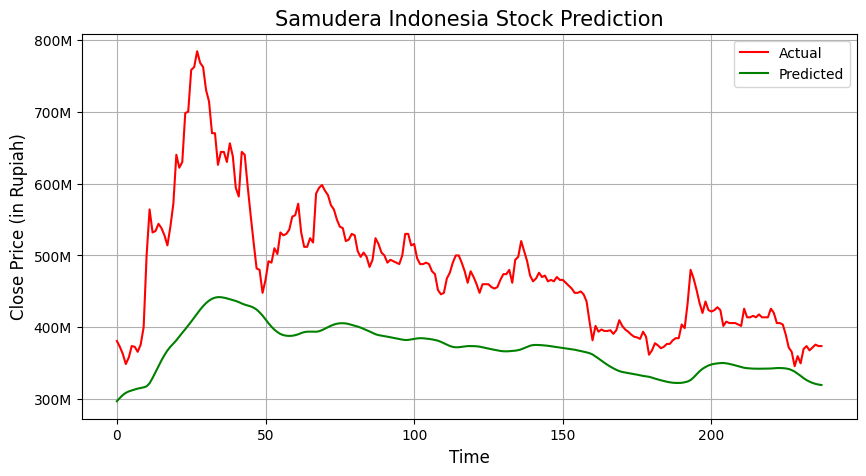

In [46]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Samudera Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/smdr_relu_rmsprop.h5')

##### ReLU - AdaDelta

In [47]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 15s 317ms/step - loss: 0.0370 - val_loss: 0.2756
Epoch 2/10
24/24 [==============================] - 6s 269ms/step - loss: 0.0365 - val_loss: 0.2735
Epoch 3/10
24/24 [==============================] - 7s 292ms/step - loss: 0.0362 - val_loss: 0.2713
Epoch 4/10
24/24 [==============================] - 7s 273ms/step - loss: 0.0357 - val_loss: 0.2692
Epoch 5/10
24/24 [==============================] - 7s 274ms/step - loss: 0.0353 - val_loss: 0.2671
Epoch 6/10
24/24 [==============================] - 6s 263ms/step - loss: 0.0349 - val_loss: 0.2650
Epoch 7/10
24/24 [==============================] - 7s 280ms/step - loss: 0.0343 - val_loss: 0.2628
Epoch 8/10
24/24 [==============================] - 7s 289ms/step - loss: 0.0338 - val_loss: 0.2606
Epoch 9/10
24/24 [==============================] - 8s 333ms/step - loss: 0.0334 - val_loss: 0.2584
Epoch 10/10
24/24 [==============================] - 8s 329ms/step - loss: 0.0331 - val_loss: 0.256

In [48]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 41ms/step
Mean Absolute Percentage Error (MAPE):  1.03148
Mean Absolute Error (MAE):  2.2254206
Mean Squared Error (MSE):  5.145092
Root Mean Squared Error (RMSE):  2.26828
R-Squared:  -27.579031


8/8 [==============================] - 0s 38ms/step


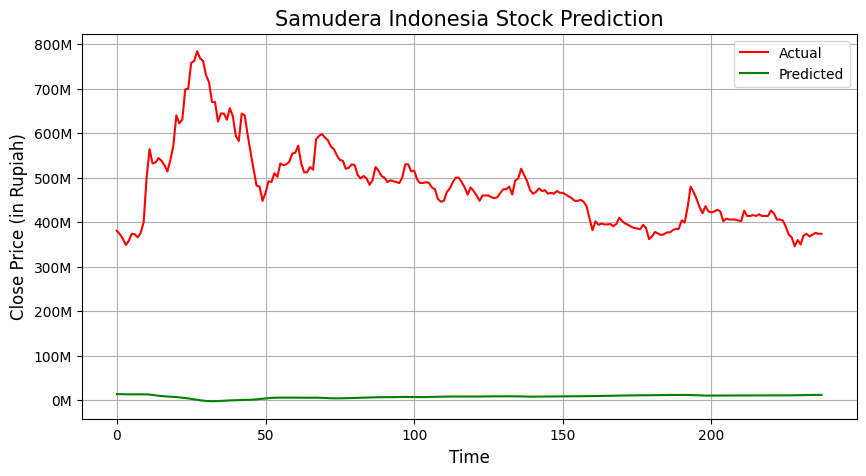

In [49]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Samudera Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/smdr_relu_adadelta.h5')

##### ReLU - SGD

In [50]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 15s 323ms/step - loss: 0.0174 - val_loss: 0.1434
Epoch 2/10
24/24 [==============================] - 7s 280ms/step - loss: 0.0095 - val_loss: 0.1248
Epoch 3/10
24/24 [==============================] - 6s 266ms/step - loss: 0.0088 - val_loss: 0.1161
Epoch 4/10
24/24 [==============================] - 6s 270ms/step - loss: 0.0086 - val_loss: 0.1129
Epoch 5/10
24/24 [==============================] - 6s 267ms/step - loss: 0.0082 - val_loss: 0.1078
Epoch 6/10
24/24 [==============================] - 7s 286ms/step - loss: 0.0078 - val_loss: 0.1053
Epoch 7/10
24/24 [==============================] - 7s 303ms/step - loss: 0.0077 - val_loss: 0.1026
Epoch 8/10
24/24 [==============================] - 7s 293ms/step - loss: 0.0074 - val_loss: 0.0991
Epoch 9/10
24/24 [==============================] - 8s 333ms/step - loss: 0.0073 - val_loss: 0.0971
Epoch 10/10
24/24 [==============================] - 8s 316ms/step - loss: 0.0069 - val_loss: 0.093

In [51]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 42ms/step
Mean Absolute Percentage Error (MAPE):  0.80655
Mean Absolute Error (MAE):  1.7499742
Mean Squared Error (MSE):  3.2246483
Root Mean Squared Error (RMSE):  1.79573
R-Squared:  -16.911696


8/8 [==============================] - 0s 40ms/step


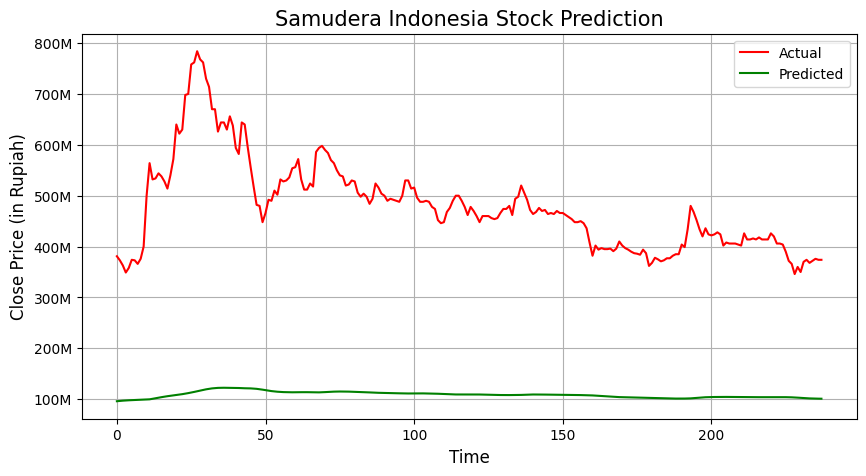

In [52]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Samudera Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/smdr_relu_sgd.h5')

##### ReLU - Adamax

In [53]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 14s 309ms/step - loss: 0.0058 - val_loss: 0.0086
Epoch 2/10
24/24 [==============================] - 6s 250ms/step - loss: 0.0012 - val_loss: 0.0029
Epoch 3/10
24/24 [==============================] - 6s 266ms/step - loss: 9.5183e-04 - val_loss: 0.0030
Epoch 4/10
24/24 [==============================] - 6s 267ms/step - loss: 8.3393e-04 - val_loss: 0.0035
Epoch 5/10
24/24 [==============================] - 6s 255ms/step - loss: 7.9516e-04 - val_loss: 0.0044
Epoch 6/10
24/24 [==============================] - 6s 258ms/step - loss: 7.7660e-04 - val_loss: 0.0039
Epoch 7/10
24/24 [==============================] - 6s 271ms/step - loss: 7.2942e-04 - val_loss: 0.0030
Epoch 8/10
24/24 [==============================] - 7s 281ms/step - loss: 6.7665e-04 - val_loss: 0.0040
Epoch 9/10
24/24 [==============================] - 6s 258ms/step - loss: 6.8105e-04 - val_loss: 0.0037
Epoch 10/10
24/24 [==============================] - 6s 265ms/step - lo

In [54]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 37ms/step
Mean Absolute Percentage Error (MAPE):  0.20011
Mean Absolute Error (MAE):  0.4540152
Mean Squared Error (MSE):  0.2649349
Root Mean Squared Error (RMSE):  0.51472
R-Squared:  -0.471612


8/8 [==============================] - 0s 37ms/step


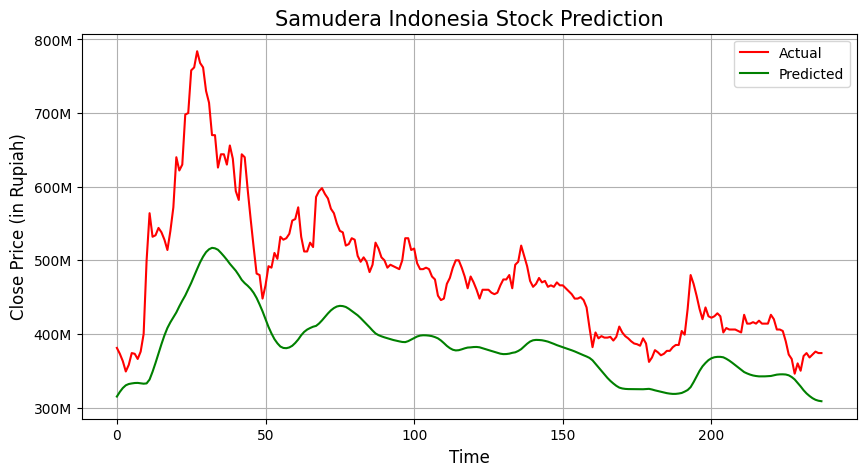

In [55]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Samudera Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/smdr_relu_adamax.h5')

##### Sigmoid - Adam

In [56]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 14s 312ms/step - loss: 0.4084 - val_loss: 0.2098
Epoch 2/10
24/24 [==============================] - 7s 270ms/step - loss: 0.0200 - val_loss: 0.1522
Epoch 3/10
24/24 [==============================] - 7s 273ms/step - loss: 0.0168 - val_loss: 0.1329
Epoch 4/10
24/24 [==============================] - 6s 264ms/step - loss: 0.0160 - val_loss: 0.1236
Epoch 5/10
24/24 [==============================] - 7s 282ms/step - loss: 0.0149 - val_loss: 0.1345
Epoch 6/10
24/24 [==============================] - 7s 281ms/step - loss: 0.0143 - val_loss: 0.1286
Epoch 7/10
24/24 [==============================] - 6s 262ms/step - loss: 0.0138 - val_loss: 0.1247
Epoch 8/10
24/24 [==============================] - 6s 265ms/step - loss: 0.0131 - val_loss: 0.1322
Epoch 9/10
24/24 [==============================] - 6s 267ms/step - loss: 0.0136 - val_loss: 0.1426
Epoch 10/10
24/24 [==============================] - 7s 273ms/step - loss: 0.0129 - val_loss: 0.127

In [57]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 36ms/step
Mean Absolute Percentage Error (MAPE):  0.88622
Mean Absolute Error (MAE):  1.9187799
Mean Squared Error (MSE):  3.8559193
Root Mean Squared Error (RMSE):  1.96365
R-Squared:  -20.418167


8/8 [==============================] - 0s 43ms/step


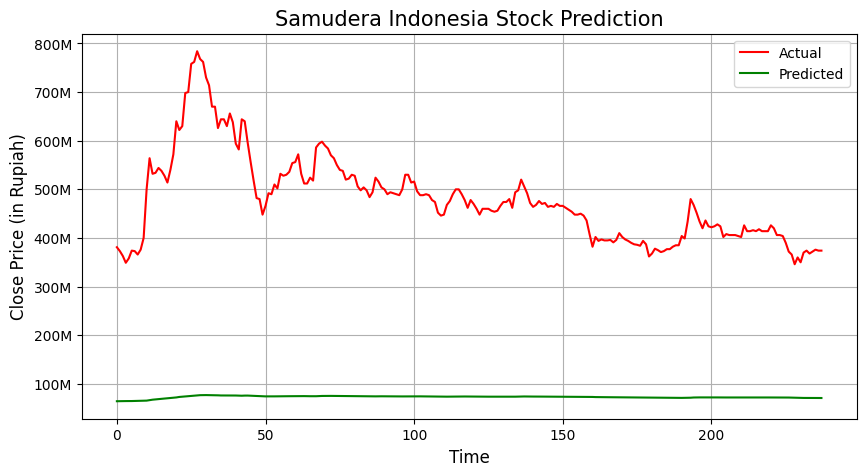

In [58]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Samudera Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/smdr_sigmoid_adam.h5')

##### Sigmoid - AdaGrad

In [59]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 14s 336ms/step - loss: 0.1355 - val_loss: 0.3965
Epoch 2/10
24/24 [==============================] - 7s 278ms/step - loss: 0.0773 - val_loss: 0.3228
Epoch 3/10
24/24 [==============================] - 7s 302ms/step - loss: 0.0516 - val_loss: 0.2769
Epoch 4/10
24/24 [==============================] - 7s 294ms/step - loss: 0.0368 - val_loss: 0.2452
Epoch 5/10
24/24 [==============================] - 7s 308ms/step - loss: 0.0278 - val_loss: 0.2220
Epoch 6/10
24/24 [==============================] - 7s 312ms/step - loss: 0.0220 - val_loss: 0.2046
Epoch 7/10
24/24 [==============================] - 7s 304ms/step - loss: 0.0182 - val_loss: 0.1911
Epoch 8/10
24/24 [==============================] - 8s 317ms/step - loss: 0.0156 - val_loss: 0.1807
Epoch 9/10
24/24 [==============================] - 9s 363ms/step - loss: 0.0139 - val_loss: 0.1725
Epoch 10/10
24/24 [==============================] - 9s 360ms/step - loss: 0.0128 - val_loss: 0.165

In [60]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 42ms/step
Mean Absolute Percentage Error (MAPE):  0.95219
Mean Absolute Error (MAE):  2.0585589
Mean Squared Error (MSE):  4.4224273
Root Mean Squared Error (RMSE):  2.10296
R-Squared:  -23.564903


8/8 [==============================] - 0s 50ms/step


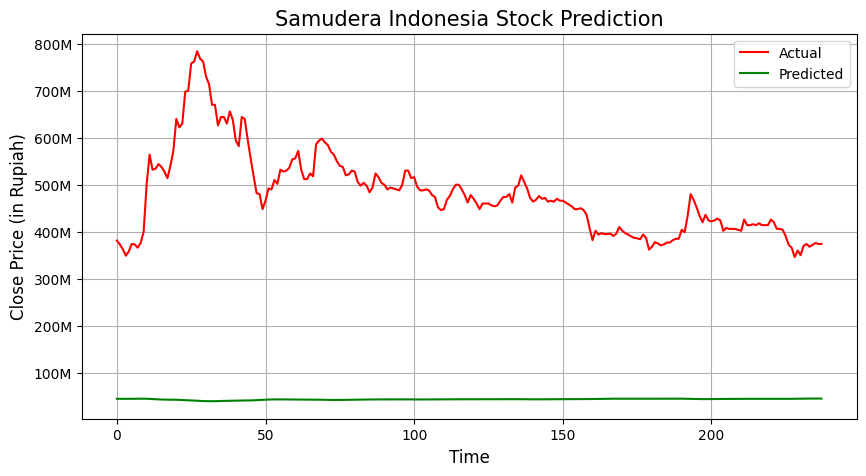

In [61]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Samudera Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/smdr_sigmoid_adagrad.h5')

##### Sigmoid - Nadam

In [62]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 20s 419ms/step - loss: 0.0172 - val_loss: 0.0215
Epoch 2/10
24/24 [==============================] - 8s 328ms/step - loss: 0.0012 - val_loss: 0.0113
Epoch 3/10
24/24 [==============================] - 7s 297ms/step - loss: 8.6520e-04 - val_loss: 0.0060
Epoch 4/10
24/24 [==============================] - 7s 296ms/step - loss: 6.2143e-04 - val_loss: 0.0053
Epoch 5/10
24/24 [==============================] - 7s 306ms/step - loss: 5.7704e-04 - val_loss: 0.0064
Epoch 6/10
24/24 [==============================] - 7s 292ms/step - loss: 5.0355e-04 - val_loss: 0.0052
Epoch 7/10
24/24 [==============================] - 7s 308ms/step - loss: 4.8114e-04 - val_loss: 0.0050
Epoch 8/10
24/24 [==============================] - 8s 336ms/step - loss: 4.5894e-04 - val_loss: 0.0057
Epoch 9/10
24/24 [==============================] - 8s 321ms/step - loss: 4.4645e-04 - val_loss: 0.0048
Epoch 10/10
24/24 [==============================] - 7s 291ms/step - lo

In [63]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 39ms/step
Mean Absolute Percentage Error (MAPE):  0.26137
Mean Absolute Error (MAE):  0.5947215
Mean Squared Error (MSE):  0.4460399
Root Mean Squared Error (RMSE):  0.66786
R-Squared:  -1.477582


8/8 [==============================] - 0s 46ms/step


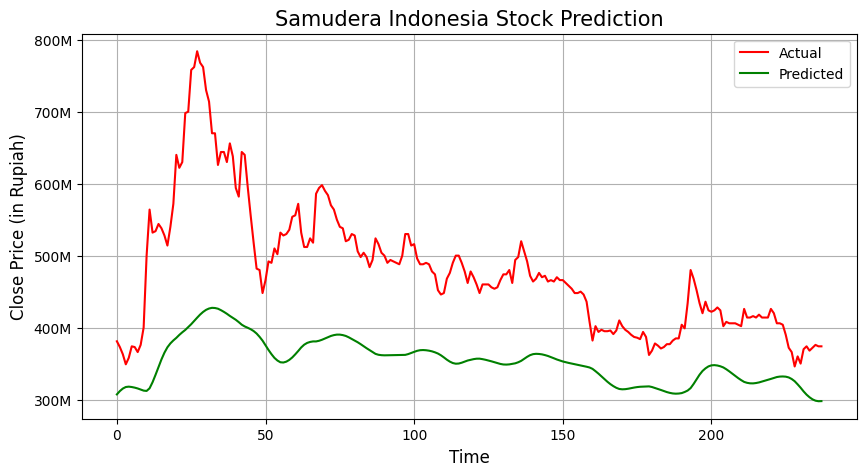

In [64]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Samudera Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/smdr_sigmoid_nadam.h5')

##### Sigmoid - RMSProp

In [65]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 14s 309ms/step - loss: 0.0108 - val_loss: 0.0407
Epoch 2/10
24/24 [==============================] - 6s 260ms/step - loss: 0.0018 - val_loss: 0.0248
Epoch 3/10
24/24 [==============================] - 6s 271ms/step - loss: 0.0017 - val_loss: 0.0052
Epoch 4/10
24/24 [==============================] - 6s 253ms/step - loss: 0.0016 - val_loss: 0.0046
Epoch 5/10
24/24 [==============================] - 6s 269ms/step - loss: 0.0012 - val_loss: 0.0062
Epoch 6/10
24/24 [==============================] - 7s 279ms/step - loss: 0.0013 - val_loss: 0.0070
Epoch 7/10
24/24 [==============================] - 7s 278ms/step - loss: 0.0012 - val_loss: 0.0101
Epoch 8/10
24/24 [==============================] - 6s 258ms/step - loss: 0.0010 - val_loss: 0.0072
Epoch 9/10
24/24 [==============================] - 6s 261ms/step - loss: 8.7836e-04 - val_loss: 0.0060
Epoch 10/10
24/24 [==============================] - 6s 257ms/step - loss: 9.5386e-04 - val_los

In [66]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 39ms/step
Mean Absolute Percentage Error (MAPE):  0.43087
Mean Absolute Error (MAE):  0.9622456
Mean Squared Error (MSE):  1.0700288
Root Mean Squared Error (RMSE):  1.03442
R-Squared:  -4.943603


8/8 [==============================] - 0s 35ms/step


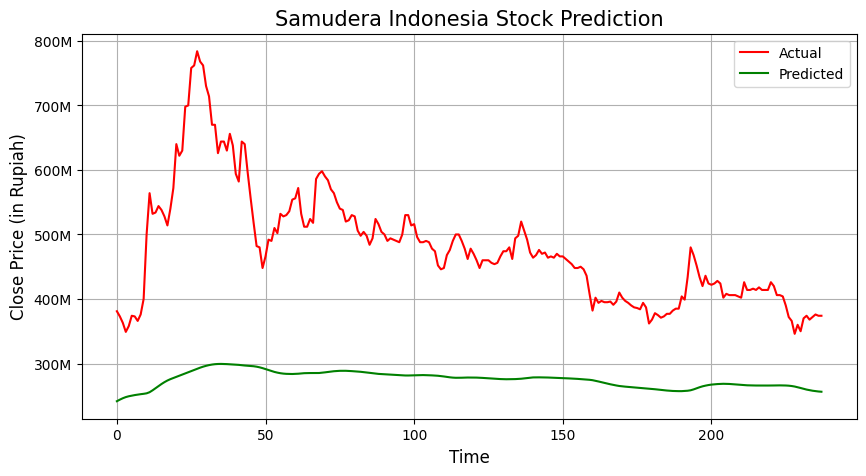

In [67]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Samudera Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/smdr_sigmoid_rmsprop.h5')

##### Sigmoid - AdaDelta

In [68]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 13s 286ms/step - loss: 0.4437 - val_loss: 0.9618
Epoch 2/10
24/24 [==============================] - 6s 233ms/step - loss: 0.4420 - val_loss: 0.9586
Epoch 3/10
24/24 [==============================] - 6s 260ms/step - loss: 0.4405 - val_loss: 0.9553
Epoch 4/10
24/24 [==============================] - 7s 277ms/step - loss: 0.4388 - val_loss: 0.9519
Epoch 5/10
24/24 [==============================] - 6s 255ms/step - loss: 0.4368 - val_loss: 0.9485
Epoch 6/10
24/24 [==============================] - 6s 264ms/step - loss: 0.4353 - val_loss: 0.9450
Epoch 7/10
24/24 [==============================] - 6s 258ms/step - loss: 0.4334 - val_loss: 0.9415
Epoch 8/10
24/24 [==============================] - 6s 267ms/step - loss: 0.4316 - val_loss: 0.9379
Epoch 9/10
24/24 [==============================] - 6s 268ms/step - loss: 0.4297 - val_loss: 0.9343
Epoch 10/10
24/24 [==============================] - 7s 277ms/step - loss: 0.4280 - val_loss: 0.930

In [69]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 41ms/step
Mean Absolute Percentage Error (MAPE):  1.23639
Mean Absolute Error (MAE):  2.6498322
Mean Squared Error (MSE):  7.2009926
Root Mean Squared Error (RMSE):  2.68347
R-Squared:  -38.998777


8/8 [==============================] - 0s 43ms/step


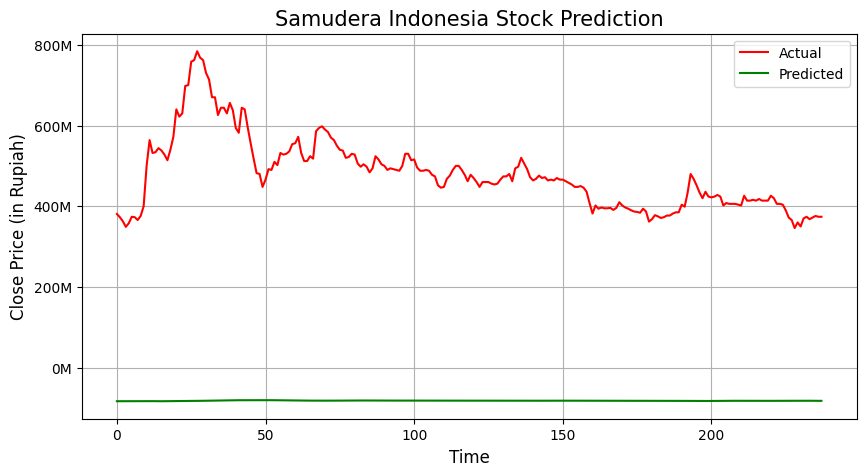

In [70]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Samudera Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/smdr_sigmoid_adadelta.h5')

##### Sigmoid - SGD

In [71]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 17s 359ms/step - loss: 0.0113 - val_loss: 0.1460
Epoch 2/10
24/24 [==============================] - 6s 268ms/step - loss: 0.0109 - val_loss: 0.1439
Epoch 3/10
24/24 [==============================] - 6s 255ms/step - loss: 0.0109 - val_loss: 0.1439
Epoch 4/10
24/24 [==============================] - 6s 267ms/step - loss: 0.0108 - val_loss: 0.1405
Epoch 5/10
24/24 [==============================] - 6s 256ms/step - loss: 0.0108 - val_loss: 0.1370
Epoch 6/10
24/24 [==============================] - 6s 256ms/step - loss: 0.0107 - val_loss: 0.1435
Epoch 7/10
24/24 [==============================] - 7s 286ms/step - loss: 0.0107 - val_loss: 0.1395
Epoch 8/10
24/24 [==============================] - 7s 283ms/step - loss: 0.0106 - val_loss: 0.1386
Epoch 9/10
24/24 [==============================] - 7s 275ms/step - loss: 0.0106 - val_loss: 0.1403
Epoch 10/10
24/24 [==============================] - 7s 274ms/step - loss: 0.0105 - val_loss: 0.137

In [72]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 43ms/step
Mean Absolute Percentage Error (MAPE):  0.92268
Mean Absolute Error (MAE):  1.9965308
Mean Squared Error (MSE):  4.1685642
Root Mean Squared Error (RMSE):  2.04171
R-Squared:  -22.15479


8/8 [==============================] - 0s 47ms/step


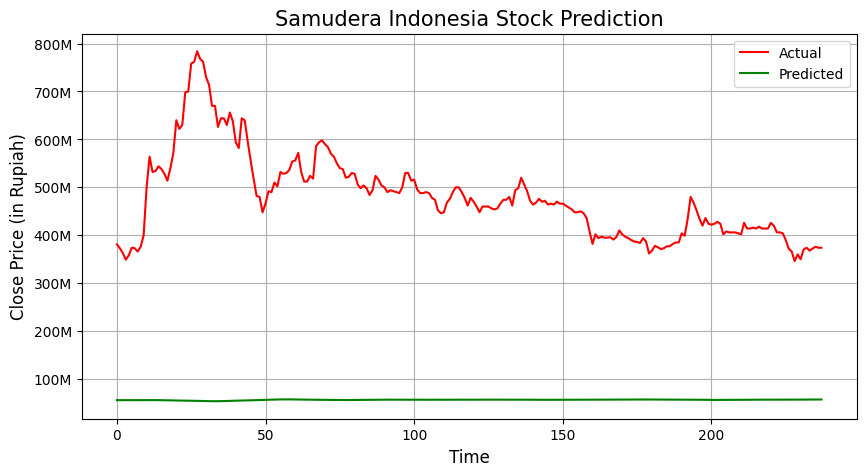

In [73]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Samudera Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/smdr_sigmoid_sgd.h5')

##### Sigmoid - Adamax

In [74]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 16s 345ms/step - loss: 0.0034 - val_loss: 0.0165
Epoch 2/10
24/24 [==============================] - 7s 284ms/step - loss: 0.0011 - val_loss: 0.0068
Epoch 3/10
24/24 [==============================] - 7s 285ms/step - loss: 7.4894e-04 - val_loss: 0.0052
Epoch 4/10
24/24 [==============================] - 7s 289ms/step - loss: 6.1251e-04 - val_loss: 0.0040
Epoch 5/10
24/24 [==============================] - 8s 324ms/step - loss: 5.8749e-04 - val_loss: 0.0050
Epoch 6/10
24/24 [==============================] - 7s 299ms/step - loss: 5.6233e-04 - val_loss: 0.0054
Epoch 7/10
24/24 [==============================] - 8s 316ms/step - loss: 4.9284e-04 - val_loss: 0.0060
Epoch 8/10
24/24 [==============================] - 9s 367ms/step - loss: 4.9598e-04 - val_loss: 0.0049
Epoch 9/10
24/24 [==============================] - 8s 314ms/step - loss: 4.4502e-04 - val_loss: 0.0041
Epoch 10/10
24/24 [==============================] - 8s 318ms/step - lo

In [75]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 3s 49ms/step
Mean Absolute Percentage Error (MAPE):  0.30299
Mean Absolute Error (MAE):  0.6840932
Mean Squared Error (MSE):  0.5679994
Root Mean Squared Error (RMSE):  0.75366
R-Squared:  -2.155021


8/8 [==============================] - 0s 47ms/step


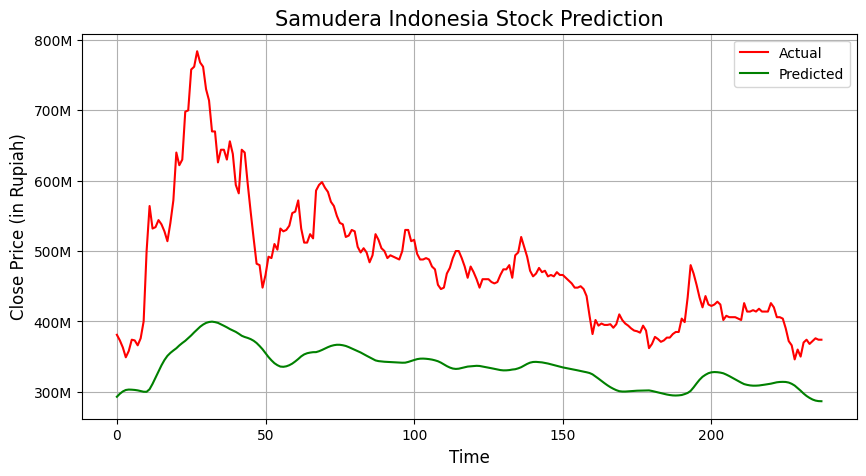

In [76]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Samudera Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/smdr_sigmoid_adamax.h5')

##### Tanh - Adam

In [77]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 17s 405ms/step - loss: 0.0049 - val_loss: 0.0039
Epoch 2/10
24/24 [==============================] - 8s 322ms/step - loss: 7.5906e-04 - val_loss: 0.0026
Epoch 3/10
24/24 [==============================] - 8s 339ms/step - loss: 6.0242e-04 - val_loss: 0.0029
Epoch 4/10
24/24 [==============================] - 8s 330ms/step - loss: 5.2592e-04 - val_loss: 0.0022
Epoch 5/10
24/24 [==============================] - 8s 321ms/step - loss: 4.7246e-04 - val_loss: 0.0039
Epoch 6/10
24/24 [==============================] - 8s 319ms/step - loss: 4.8863e-04 - val_loss: 0.0021
Epoch 7/10
24/24 [==============================] - 7s 306ms/step - loss: 3.8774e-04 - val_loss: 0.0026
Epoch 8/10
24/24 [==============================] - 8s 332ms/step - loss: 4.1204e-04 - val_loss: 0.0018
Epoch 9/10
24/24 [==============================] - 8s 350ms/step - loss: 4.1569e-04 - val_loss: 0.0029
Epoch 10/10
24/24 [==============================] - 8s 349ms/step 

In [78]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 45ms/step
Mean Absolute Percentage Error (MAPE):  0.16812
Mean Absolute Error (MAE):  0.3840621
Mean Squared Error (MSE):  0.1964862
Root Mean Squared Error (RMSE):  0.44327
R-Squared:  -0.091406


8/8 [==============================] - 0s 49ms/step


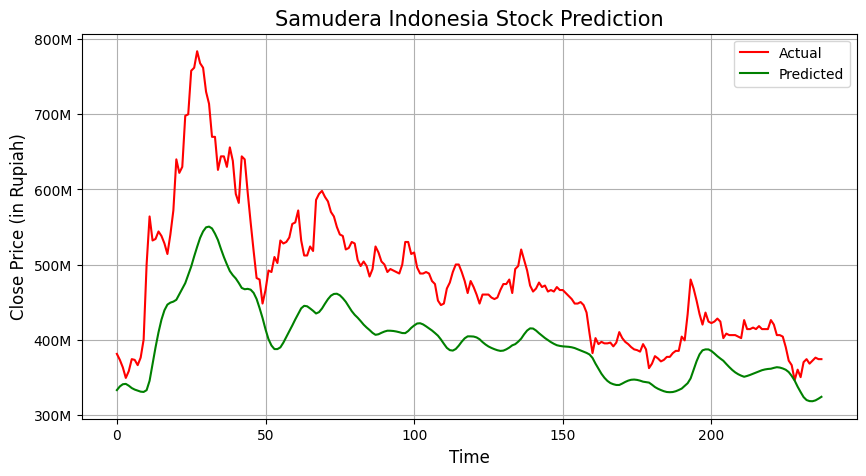

In [79]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Samudera Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/smdr_tanh_adam.h5')

##### Tanh - AdaGrad

In [80]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 17s 400ms/step - loss: 0.0141 - val_loss: 0.1199
Epoch 2/10
24/24 [==============================] - 8s 324ms/step - loss: 0.0081 - val_loss: 0.1031
Epoch 3/10
24/24 [==============================] - 9s 361ms/step - loss: 0.0075 - val_loss: 0.0973
Epoch 4/10
24/24 [==============================] - 8s 336ms/step - loss: 0.0072 - val_loss: 0.0946
Epoch 5/10
24/24 [==============================] - 9s 364ms/step - loss: 0.0070 - val_loss: 0.0920
Epoch 6/10
24/24 [==============================] - 8s 338ms/step - loss: 0.0069 - val_loss: 0.0900
Epoch 7/10
24/24 [==============================] - 8s 338ms/step - loss: 0.0066 - val_loss: 0.0876
Epoch 8/10
24/24 [==============================] - 8s 343ms/step - loss: 0.0067 - val_loss: 0.0857
Epoch 9/10
24/24 [==============================] - 8s 327ms/step - loss: 0.0064 - val_loss: 0.0840
Epoch 10/10
24/24 [==============================] - 8s 333ms/step - loss: 0.0063 - val_loss: 0.081

In [81]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 45ms/step
Mean Absolute Percentage Error (MAPE):  0.74317
Mean Absolute Error (MAE):  1.6159812
Mean Squared Error (MSE):  2.7662738
Root Mean Squared Error (RMSE):  1.66321
R-Squared:  -14.3656


8/8 [==============================] - 0s 46ms/step


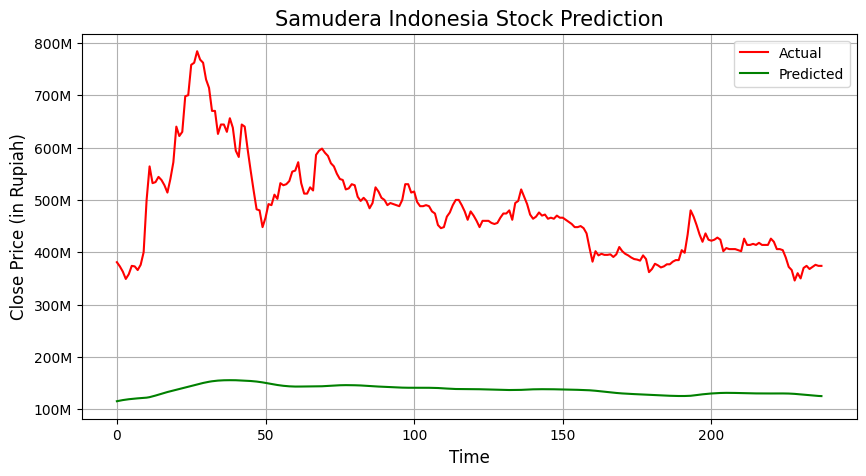

In [82]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Samudera Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/smdr_tanh_adagrad.h5')

##### Tanh - Nadam

In [83]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 19s 398ms/step - loss: 0.0038 - val_loss: 0.0027
Epoch 2/10
24/24 [==============================] - 8s 348ms/step - loss: 6.8674e-04 - val_loss: 0.0030
Epoch 3/10
24/24 [==============================] - 10s 417ms/step - loss: 5.2837e-04 - val_loss: 0.0033
Epoch 4/10
24/24 [==============================] - 9s 355ms/step - loss: 5.0122e-04 - val_loss: 0.0020
Epoch 5/10
24/24 [==============================] - 8s 341ms/step - loss: 4.2375e-04 - val_loss: 0.0021
Epoch 6/10
24/24 [==============================] - 8s 353ms/step - loss: 4.3356e-04 - val_loss: 0.0045
Epoch 7/10
24/24 [==============================] - 8s 335ms/step - loss: 4.4088e-04 - val_loss: 0.0019
Epoch 8/10
24/24 [==============================] - 8s 325ms/step - loss: 3.7432e-04 - val_loss: 0.0020
Epoch 9/10
24/24 [==============================] - 8s 331ms/step - loss: 3.5757e-04 - val_loss: 0.0031
Epoch 10/10
24/24 [==============================] - 8s 324ms/step

In [84]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 3s 53ms/step
Mean Absolute Percentage Error (MAPE):  0.24308
Mean Absolute Error (MAE):  0.5425508
Mean Squared Error (MSE):  0.3473152
Root Mean Squared Error (RMSE):  0.58933
R-Squared:  -0.929204


8/8 [==============================] - 1s 60ms/step


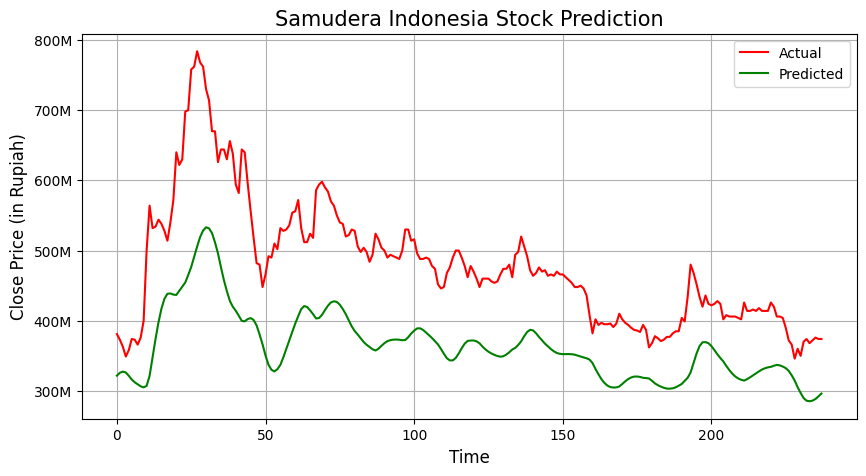

In [85]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Samudera Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/smdr_tanh_nadam.h5')

##### Tanh - RMSProp

In [86]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 17s 391ms/step - loss: 0.0043 - val_loss: 0.0044
Epoch 2/10
24/24 [==============================] - 8s 345ms/step - loss: 0.0016 - val_loss: 0.0045
Epoch 3/10
24/24 [==============================] - 8s 348ms/step - loss: 0.0013 - val_loss: 0.0038
Epoch 4/10
24/24 [==============================] - 8s 338ms/step - loss: 0.0012 - val_loss: 0.0059
Epoch 5/10
24/24 [==============================] - 8s 331ms/step - loss: 9.8382e-04 - val_loss: 0.0025
Epoch 6/10
24/24 [==============================] - 8s 334ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 7/10
24/24 [==============================] - 8s 356ms/step - loss: 9.7144e-04 - val_loss: 0.0023
Epoch 8/10
24/24 [==============================] - 8s 351ms/step - loss: 9.3442e-04 - val_loss: 0.0048
Epoch 9/10
24/24 [==============================] - 9s 357ms/step - loss: 7.7288e-04 - val_loss: 0.0033
Epoch 10/10
24/24 [==============================] - 8s 350ms/step - loss: 7.4343e-

In [87]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 47ms/step
Mean Absolute Percentage Error (MAPE):  0.21239
Mean Absolute Error (MAE):  0.4847003
Mean Squared Error (MSE):  0.3117816
Root Mean Squared Error (RMSE):  0.55837
R-Squared:  -0.731828


8/8 [==============================] - 0s 45ms/step


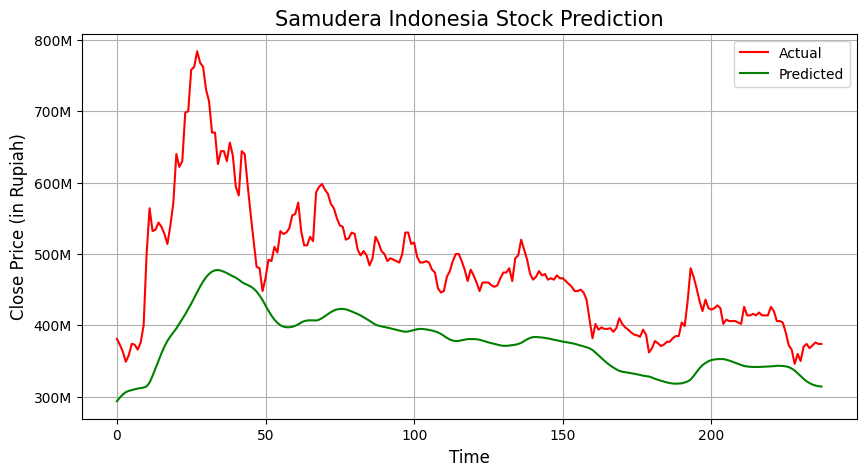

In [88]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Samudera Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/smdr_tanh_rmsprop.h5')

##### Tanh - AdaDelta

In [89]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 17s 381ms/step - loss: 0.0337 - val_loss: 0.2466
Epoch 2/10
24/24 [==============================] - 8s 323ms/step - loss: 0.0332 - val_loss: 0.2427
Epoch 3/10
24/24 [==============================] - 8s 334ms/step - loss: 0.0319 - val_loss: 0.2389
Epoch 4/10
24/24 [==============================] - 7s 304ms/step - loss: 0.0314 - val_loss: 0.2350
Epoch 5/10
24/24 [==============================] - 7s 300ms/step - loss: 0.0309 - val_loss: 0.2312
Epoch 6/10
24/24 [==============================] - 7s 305ms/step - loss: 0.0298 - val_loss: 0.2273
Epoch 7/10
24/24 [==============================] - 8s 322ms/step - loss: 0.0293 - val_loss: 0.2236
Epoch 8/10
24/24 [==============================] - 8s 318ms/step - loss: 0.0285 - val_loss: 0.2198
Epoch 9/10
24/24 [==============================] - 8s 331ms/step - loss: 0.0278 - val_loss: 0.2161
Epoch 10/10
24/24 [==============================] - 8s 316ms/step - loss: 0.0267 - val_loss: 0.212

In [90]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 46ms/step
Mean Absolute Percentage Error (MAPE):  0.92851
Mean Absolute Error (MAE):  2.0051143
Mean Squared Error (MSE):  4.1867567
Root Mean Squared Error (RMSE):  2.04616
R-Squared:  -22.255843


8/8 [==============================] - 0s 45ms/step


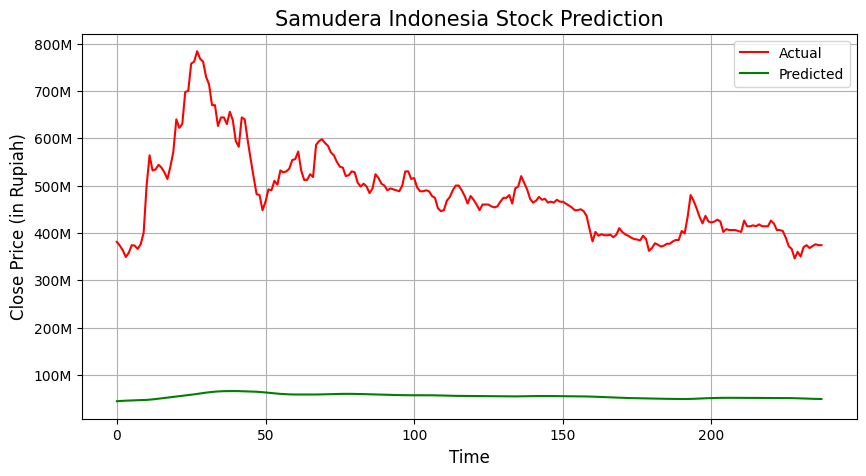

In [91]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Samudera Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/smdr_tanh_adadelta.h5')

##### Tanh - SGD

In [92]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 18s 396ms/step - loss: 0.0153 - val_loss: 0.1461
Epoch 2/10
24/24 [==============================] - 8s 314ms/step - loss: 0.0107 - val_loss: 0.1370
Epoch 3/10
24/24 [==============================] - 8s 318ms/step - loss: 0.0103 - val_loss: 0.1326
Epoch 4/10
24/24 [==============================] - 8s 314ms/step - loss: 0.0099 - val_loss: 0.1276
Epoch 5/10
24/24 [==============================] - 8s 327ms/step - loss: 0.0097 - val_loss: 0.1201
Epoch 6/10
24/24 [==============================] - 8s 323ms/step - loss: 0.0090 - val_loss: 0.1136
Epoch 7/10
24/24 [==============================] - 8s 329ms/step - loss: 0.0087 - val_loss: 0.1129
Epoch 8/10
24/24 [==============================] - 8s 328ms/step - loss: 0.0084 - val_loss: 0.1063
Epoch 9/10
24/24 [==============================] - 8s 314ms/step - loss: 0.0080 - val_loss: 0.1026
Epoch 10/10
24/24 [==============================] - 8s 321ms/step - loss: 0.0076 - val_loss: 0.098

In [93]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 44ms/step
Mean Absolute Percentage Error (MAPE):  0.78862
Mean Absolute Error (MAE):  1.711746
Mean Squared Error (MSE):  3.0892888
Root Mean Squared Error (RMSE):  1.75764
R-Squared:  -16.159825


8/8 [==============================] - 0s 43ms/step


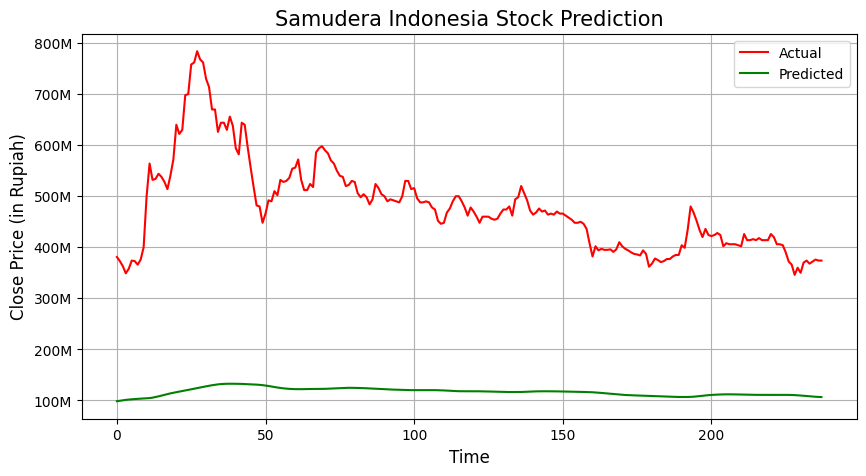

In [94]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Samudera Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/smdr_tanh_sgd.h5')

##### Tanh - Adamax

In [95]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 17s 391ms/step - loss: 0.0046 - val_loss: 0.0038
Epoch 2/10
24/24 [==============================] - 7s 285ms/step - loss: 9.9754e-04 - val_loss: 0.0026
Epoch 3/10
24/24 [==============================] - 7s 305ms/step - loss: 8.0761e-04 - val_loss: 0.0041
Epoch 4/10
24/24 [==============================] - 8s 315ms/step - loss: 7.5160e-04 - val_loss: 0.0031
Epoch 5/10
24/24 [==============================] - 7s 301ms/step - loss: 7.1224e-04 - val_loss: 0.0037
Epoch 6/10
24/24 [==============================] - 7s 298ms/step - loss: 6.4080e-04 - val_loss: 0.0034
Epoch 7/10
24/24 [==============================] - 7s 306ms/step - loss: 6.1332e-04 - val_loss: 0.0032
Epoch 8/10
24/24 [==============================] - 7s 295ms/step - loss: 6.0392e-04 - val_loss: 0.0030
Epoch 9/10
24/24 [==============================] - 7s 299ms/step - loss: 5.7098e-04 - val_loss: 0.0030
Epoch 10/10
24/24 [==============================] - 8s 318ms/step 

In [96]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 50ms/step
Mean Absolute Percentage Error (MAPE):  0.14785
Mean Absolute Error (MAE):  0.3443736
Mean Squared Error (MSE):  0.1795206
Root Mean Squared Error (RMSE):  0.4237
R-Squared:  0.002831


8/8 [==============================] - 0s 46ms/step


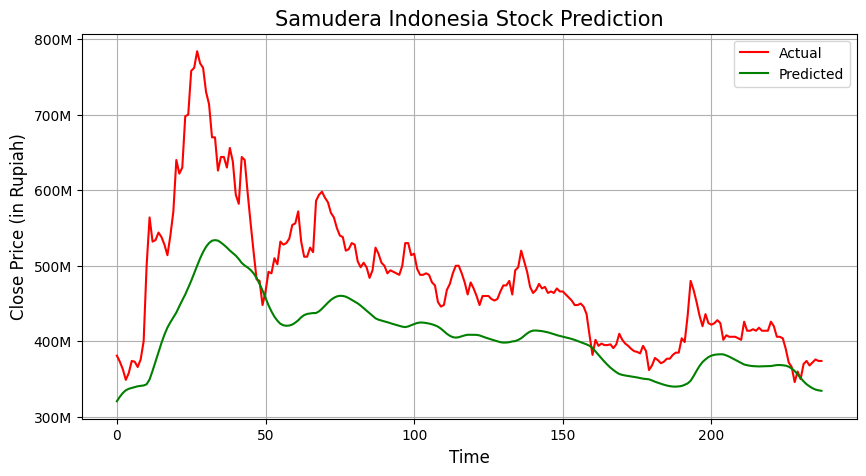

In [97]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Samudera Indonesia Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/smdr_tanh_adamax.h5')

##### Comparison LSTM Model based on Activation and Optimizer Parameter

In [98]:
# Define the activation functions and optimizers to be tested
activations = ['linear', 'relu', 'tanh', 'sigmoid']
optimizers = ['adam', 'adagrad', 'nadam', 'rmsprop', 'adadelta', 'sgd', 'adamax']

# Generate all possible combinations of activation functions and optimizers
combinations = list(itertools.product(activations, optimizers))

# Define a function to build and train an LSTM model with a given activation function and optimizer
def build_model(activations, optimizers):
    model = Sequential()
    model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation=activations))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizers)
    model.fit(X_train, y_train, batch_size=100, epochs=10, validation_split=0.1, verbose=0)
    return model

# Train and evaluate the models for all possible combinations of activation functions and optimizers
results = []
for activations, optimizers in combinations:
    print(f'Training model with {activations} activation and {optimizers} optimizer')
    start_time = time.time()
    model = build_model(activations, optimizers)
    end_time = time.time()
    preds = model.predict(X_test)
    mape = round(metrics.mean_absolute_percentage_error(y_test, preds), 5)
    mae = round(metrics.mean_absolute_error(y_test, preds), 5)
    mse = round(metrics.mean_squared_error(y_test, preds), 5)
    rmse = round(math.sqrt(mse), 5)
    r2 = round(metrics.r2_score(y_test, preds), 2)
    elapsed_time = round(end_time - start_time, 2)
    results.append([activations, optimizers, mape, mae, mse, rmse, r2, elapsed_time])

# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 
                                           'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)'], 
                                 index=['Activation', 'Optimizer'])

Training model with linear activation and adam optimizer
8/8 [==============================] - 2s 48ms/step
Training model with linear activation and adagrad optimizer
8/8 [==============================] - 2s 42ms/step
Training model with linear activation and nadam optimizer
8/8 [==============================] - 2s 42ms/step
Training model with linear activation and rmsprop optimizer
8/8 [==============================] - 2s 36ms/step
Training model with linear activation and adadelta optimizer
8/8 [==============================] - 3s 64ms/step
Training model with linear activation and sgd optimizer
8/8 [==============================] - 2s 40ms/step
Training model with linear activation and adamax optimizer
8/8 [==============================] - 2s 37ms/step
Training model with relu activation and adam optimizer
8/8 [==============================] - 2s 42ms/step
Training model with relu activation and adagrad optimizer
8/8 [==============================] - 2s 53ms/step
Training

In [99]:
# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 
                                           'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)'], 
                                 index=['Activation', 'Optimizer'])
# Get several LSTM model evaluation 
df_pivot_result.sort_values(by=['Activation', 'Optimizer'], ascending=True)

Elapsed Time (min)  MAE (%)  MAPE (%)  MSE (%)  \
Activation Optimizer                                                   
linear     adadelta                86.09  2.19743   1.01794  5.02203   
           adagrad                 77.06  1.96786   0.90840  4.06032   
           adam                    79.35  0.27197   0.12057  0.10495   
           adamax                  75.14  0.17327   0.07231  0.06782   
           nadam                   84.08  0.31595   0.14094  0.13158   
           rmsprop                 76.82  0.38773   0.17020  0.20798   
           sgd                    101.43  1.59244   0.73213  2.68924   
relu       adadelta                81.69  2.09285   0.96988  4.55245   
           adagrad                 83.32  2.00219   0.92480  4.19743   
           adam                    70.68  0.45707   0.20332  0.25692   
           adamax                  74.44  0.54856   0.24499  0.36131   
           nadam                   98.89  0.54895   0.24939  0.34506   
           rmsprop                 91.13  0.49986   0.21867  0.33157   
           sgd                     84.47  1.84826   0.85251  3.58950   
sigmoid    adadelta                81.00  1.22705   0.55339  1.68894   
           adagrad                 73.07  2.03718   0.94254  4.32869   
           adam                    70.75  0.80534   0.35625  0.78717   
           adamax                  90.54  1.51047   0.69012  2.45764   
           nadam                   82.47  1.25231   0.56661  1.74146   
           rmsprop                 80.21  1.27830   0.58157  1.78493   
           sgd                     90.09  1.99772   0.92343  4.17120   
tanh       adadelta                77.21  2.05007   0.94945  4.37417   
           adagrad                 76.19  1.76204   0.81196  3.27044   
           adam                    75.51  0.34388   0.15134  0.15935   
           adamax                  73.84  0.29500   0.12759  0.13136   
           nadam                   79.48  0.56126   0.24947  0.38118   
           rmsprop                 77.65  0.49177   0.21545  0.31900   
           sgd                     76.35  1.35626   0.62063  1.97660   

                      R-Squared (%)  RMSE (%)  
Activation Optimizer                           
linear     adadelta          -26.90   2.24099  
           adagrad           -21.55   2.01502  
           adam                0.42   0.32396  
           adamax              0.62   0.26042  
           nadam               0.27   0.36274  
           rmsprop            -0.16   0.45605  
           sgd               -13.94   1.63989  
relu       adadelta          -24.29   2.13365  
           adagrad           -22.32   2.04876  
           adam               -0.43   0.50687  
           adamax             -1.01   0.60109  
           nadam              -0.92   0.58742  
           rmsprop            -0.84   0.57582  
           sgd               -18.94   1.89460  
sigmoid    adadelta           -8.38   1.29959  
           adagrad           -23.04   2.08055  
           adam               -3.37   0.88723  
           adamax            -12.65   1.56769  
           nadam              -8.67   1.31964  
           rmsprop            -8.91   1.33601  
           sgd               -22.17   2.04235  
tanh       adadelta          -23.30   2.09145  
           adagrad           -17.17   1.80844  
           adam                0.11   0.39919  
           adamax              0.27   0.36244  
           nadam              -1.12   0.61740  
           rmsprop            -0.77   0.56480  
           sgd                -9.98   1.40592

In [100]:
# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 
                                           'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)'], 
                                 index=['Activation', 'Optimizer'])

# Calculate t-statistics and p-values for each performance metric
for col in ['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)']:
    t_stat, p_val = stats.ttest_1samp(df_result[col], 0.05)
    new_col_name_tstat = '{} (t-Statistic)'.format(col)
    new_col_name_pval = '{} (p-Value)'.format(col)
    df_pivot_result[new_col_name_tstat] = round(t_stat, 5)
    df_pivot_result[new_col_name_pval] = round(p_val, 5)

# Print the resulting pivot table with the horizontal t-statistic and p-value columns
df_pivot_result.sort_values(by=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'Elapsed Time (min)'], ascending=True)

Elapsed Time (min)  MAE (%)  MAPE (%)  MSE (%)  \
Activation Optimizer                                                   
linear     adamax                  75.14  0.17327   0.07231  0.06782   
           adam                    79.35  0.27197   0.12057  0.10495   
tanh       adamax                  73.84  0.29500   0.12759  0.13136   
linear     nadam                   84.08  0.31595   0.14094  0.13158   
tanh       adam                    75.51  0.34388   0.15134  0.15935   
linear     rmsprop                 76.82  0.38773   0.17020  0.20798   
relu       adam                    70.68  0.45707   0.20332  0.25692   
tanh       rmsprop                 77.65  0.49177   0.21545  0.31900   
relu       rmsprop                 91.13  0.49986   0.21867  0.33157   
           adamax                  74.44  0.54856   0.24499  0.36131   
           nadam                   98.89  0.54895   0.24939  0.34506   
tanh       nadam                   79.48  0.56126   0.24947  0.38118   
sigmoid    adam                    70.75  0.80534   0.35625  0.78717   
           adadelta                81.00  1.22705   0.55339  1.68894   
           nadam                   82.47  1.25231   0.56661  1.74146   
           rmsprop                 80.21  1.27830   0.58157  1.78493   
tanh       sgd                     76.35  1.35626   0.62063  1.97660   
sigmoid    adamax                  90.54  1.51047   0.69012  2.45764   
linear     sgd                    101.43  1.59244   0.73213  2.68924   
tanh       adagrad                 76.19  1.76204   0.81196  3.27044   
relu       sgd                     84.47  1.84826   0.85251  3.58950   
linear     adagrad                 77.06  1.96786   0.90840  4.06032   
sigmoid    sgd                     90.09  1.99772   0.92343  4.17120   
relu       adagrad                 83.32  2.00219   0.92480  4.19743   
sigmoid    adagrad                 73.07  2.03718   0.94254  4.32869   
tanh       adadelta                77.21  2.05007   0.94945  4.37417   
relu       adadelta                81.69  2.09285   0.96988  4.55245   
linear     adadelta                86.09  2.19743   1.01794  5.02203   

                      R-Squared (%)  RMSE (%)  MAPE (%) (t-Statistic)  \
Activation Optimizer                                                    
linear     adamax              0.62   0.26042                 7.43179   
           adam                0.42   0.32396                 7.43179   
tanh       adamax              0.27   0.36244                 7.43179   
linear     nadam               0.27   0.36274                 7.43179   
tanh       adam                0.11   0.39919                 7.43179   
linear     rmsprop            -0.16   0.45605                 7.43179   
relu       adam               -0.43   0.50687                 7.43179   
tanh       rmsprop            -0.77   0.56480                 7.43179   
relu       rmsprop            -0.84   0.57582                 7.43179   
           adamax             -1.01   0.60109                 7.43179   
           nadam              -0.92   0.58742                 7.43179   
tanh       nadam              -1.12   0.61740                 7.43179   
sigmoid    adam               -3.37   0.88723                 7.43179   
           adadelta           -8.38   1.29959                 7.43179   
           nadam              -8.67   1.31964                 7.43179   
           rmsprop            -8.91   1.33601                 7.43179   
tanh       sgd                -9.98   1.40592                 7.43179   
sigmoid    adamax            -12.65   1.56769                 7.43179   
linear     sgd               -13.94   1.63989                 7.43179   
tanh       adagrad           -17.17   1.80844                 7.43179   
relu       sgd               -18.94   1.89460                 7.43179   
linear     adagrad           -21.55   2.01502                 7.43179   
sigmoid    sgd               -22.17   2.04235                 7.43179   
relu       adagrad           -22.32 

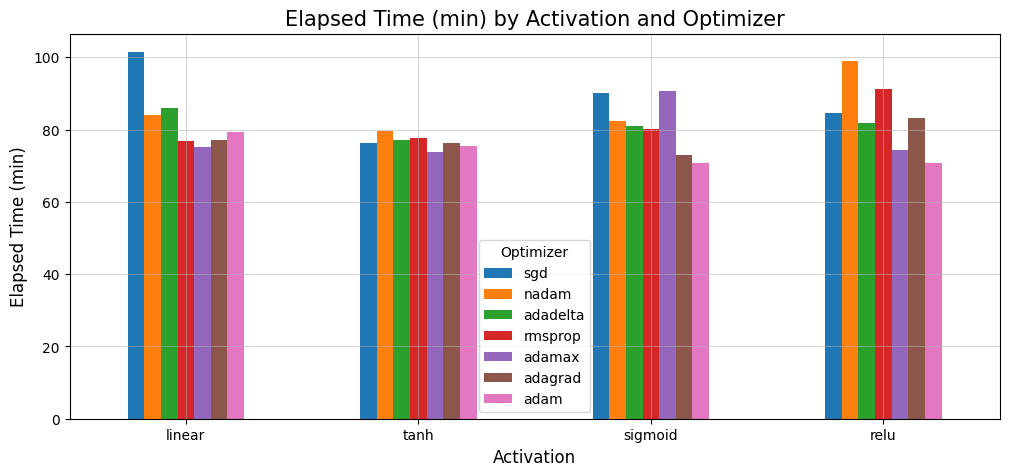

In [101]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_time = df_result.pivot_table(index='Activation', columns='Optimizer', values='Elapsed Time (min)')
# Sort the columns based on the mean elapsed time value
df_time = df_time[df_time.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_time = df_time.sort_index(ascending=True)
# Sort the values in the x-axis in descending order based on the highest mean elapsed time value
df_time = df_time.sort_values(by=df_time.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_time.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Elapsed Time (min)', fontsize=12)
ax.set_title('Elapsed Time (min) by Activation and Optimizer', fontsize=15)
# formatter = ticker.PercentFormatter(xmax=1, decimals=0)
# ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.show()

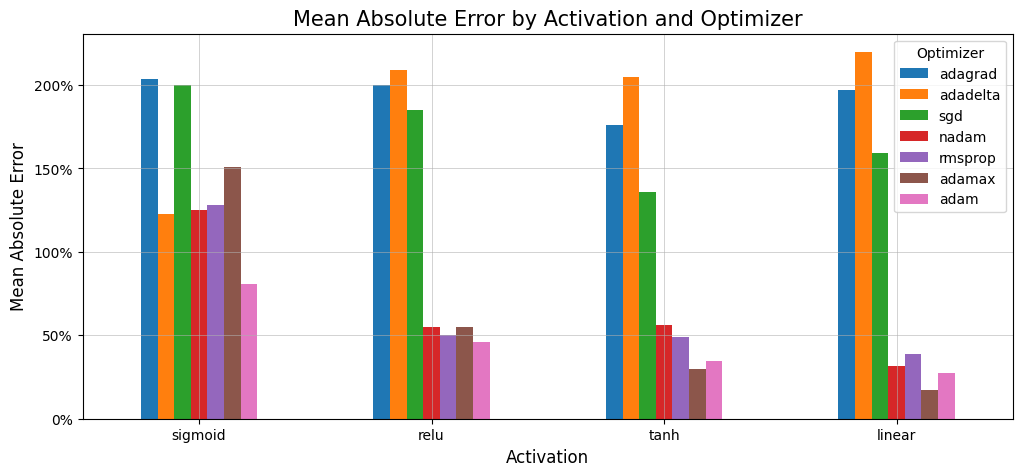

In [102]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mae = df_result.pivot_table(index='Activation', columns='Optimizer', values='MAE (%)')
# Sort the columns based on the mean MAE value
df_mae = df_mae[df_mae.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mae = df_mae.sort_index(ascending=True)
# Sort the values in the x-axis in descending order based on the highest mean MAE value
df_mae = df_mae.sort_values(by=df_mae.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_mae.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Mean Absolute Error', fontsize=12)
ax.set_title('Mean Absolute Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

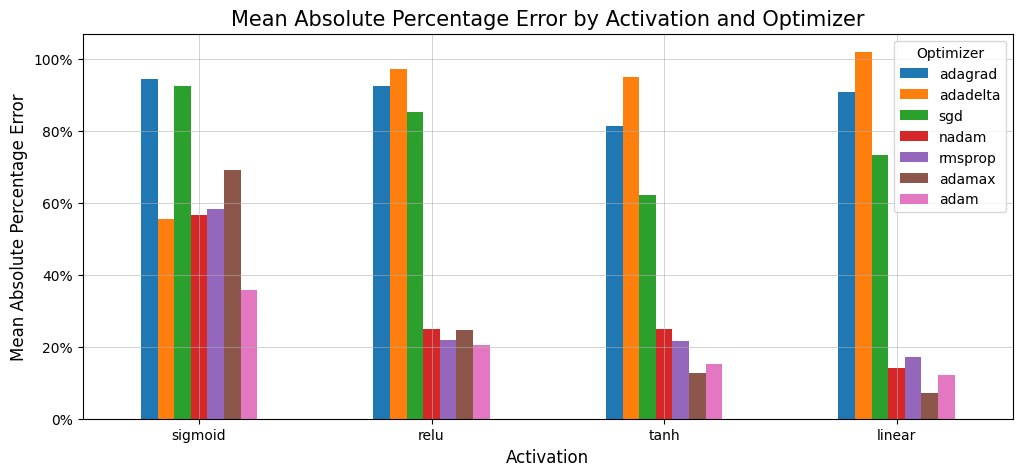

In [103]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mape = df_result.pivot_table(index='Activation', columns='Optimizer', values='MAPE (%)')
# Sort the columns based on the mean MAPE value
df_mape = df_mape[df_mae.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mape = df_mape.sort_index(ascending=True)
# Sort the values in the x-axis in descending order based on the highest mean MAPE value
df_mape = df_mape.sort_values(by=df_mape.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_mape.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Mean Absolute Percentage Error', fontsize=12)
ax.set_title('Mean Absolute Percentage Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

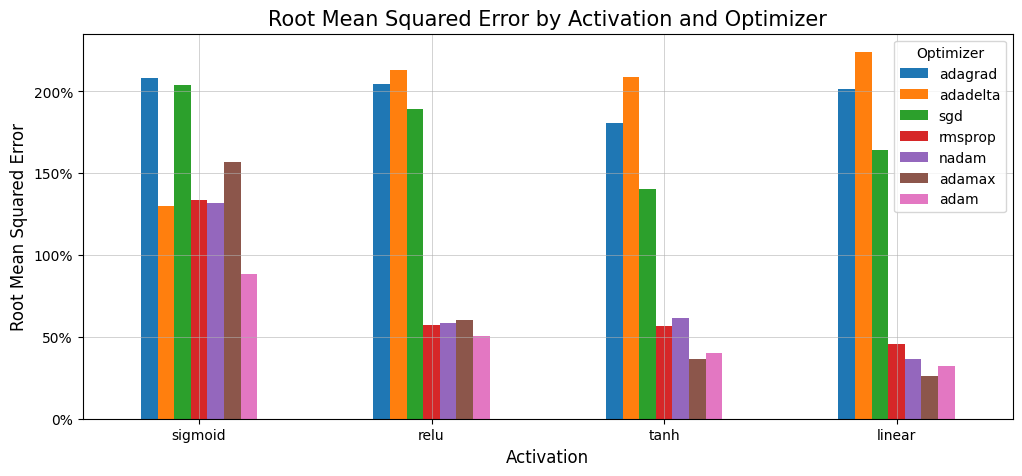

In [104]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_rmse = df_result.pivot_table(index='Activation', columns='Optimizer', values='RMSE (%)')
# Sort the columns based on the mean RMSE value
df_rmse = df_rmse[df_rmse.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_rmse = df_rmse.sort_index(ascending=True)
# Sort the values in the x-axis in descending order based on the highest mean RMSE value
df_rmse = df_rmse.sort_values(by=df_rmse.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_rmse.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Root Mean Squared Error', fontsize=12)
ax.set_title('Root Mean Squared Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

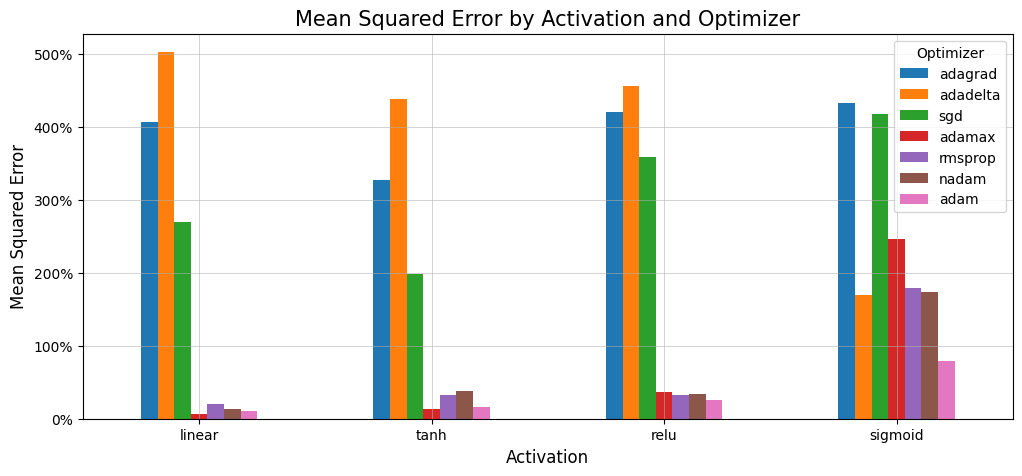

In [116]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mse = df_result.pivot_table(index='Activation', columns='Optimizer', values='MSE (%)')
# Sort the columns based on the mean RMSE value
df_mse = df_mse[df_mse.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mse = df_mse.sort_index(ascending=True)
# Sort the values in the x-axis in descending order based on the highest mean RMSE value
df_mse = df_mse.sort_values(by=df_mse.columns[-1], ascending=True)

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_mse.plot(kind='bar', ax=ax) # modified line
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Mean Squared Error', fontsize=12) # modified line
ax.set_title('Mean Squared Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter) # modified line
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0) # modified line
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

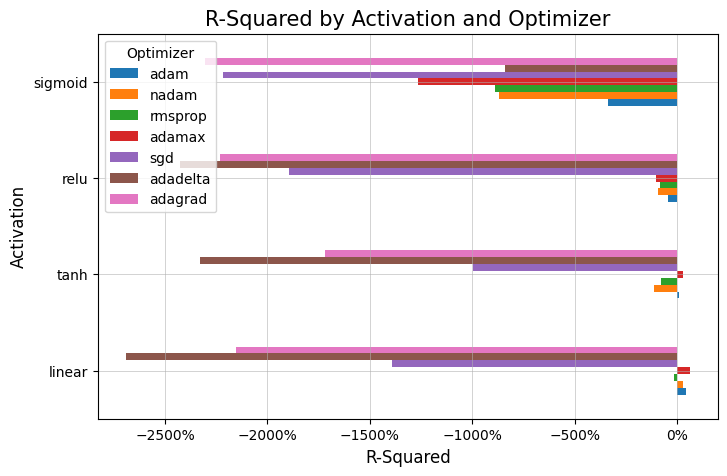

In [115]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_r2 = df_result.pivot_table(index='Activation', columns='Optimizer', values='R-Squared (%)')
# Sort the columns based on the mean RMSE value
df_r2 = df_r2[df_r2.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_r2 = df_r2.sort_index(ascending=True)
# Sort the values in the x-axis in descending order based on the highest mean RMSE value
df_r2 = df_r2.sort_values(by=df_rmse.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(8,5))
df_r2.plot(kind='barh', ax=ax)
ax.set_xlabel('R-Squared', fontsize=12)
ax.set_ylabel('Activation', fontsize=12)
ax.set_title('R-Squared by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.xaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()